In [1]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cmocean
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from matplotlib.collections import PatchCollection
from dask.distributed import Client, wait
from matplotlib.patches import Polygon
#import cmocea
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MultipleLocator
import cartopy.feature as cfeature


### Open files

In [ ]:
file_path = Path("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/040_connectivity_analysis_05m/")

In [ ]:
ds_conn_07 = xr.open_dataset(str(file_path / "040_connectivity_analysis_05m_00-07days.nc"))

In [ ]:
ds_conn_14 = xr.open_dataset(str(file_path / "040_connectivity_analysis_05m_07-14days.nc"))

In [ ]:
ds_conn_28 = xr.open_dataset(str(file_path / "040_connectivity_analysis_05m_07-28days.nc"))

### Normalization

In [6]:
ds_conn_07["obs_per_origin_area"] = ds_conn_07.obs / ds_conn_07.water_fraction_hex0

In [7]:
ds_conn_14["obs_per_origin_area"] = ds_conn_14.obs / ds_conn_14.water_fraction_hex0

In [8]:
ds_conn_28["obs_per_origin_area"] = ds_conn_28.obs / ds_conn_28.water_fraction_hex0

### Labellig habitable zones
- depth < 85m, rest sites, aquaculture, historic sites, known disease sites, known healthy sites

In [9]:
def label_habitable(ds):
    ds["habitable_hex0"] = (
        (ds.depth_median_hex0 < 85)
        | (ds.his_count_hex0 > 0)
        | (ds.rst_count_hex0 > 0)
        | (ds.aqc_count_hex0 > 0)
        | (ds.dss_count_hex0 > 0)
        | (ds.hly_count_hex0 > 0)
    )
    ds["habitable_hex1"] = (
        (ds.depth_median_hex1 < 85)
        | (ds.rst_count_hex1 > 0)
        | (ds.his_count_hex1 > 0)
        | (ds.aqc_count_hex1 > 0)
        | (ds.dss_count_hex1 > 0)
        | (ds.hly_count_hex1 > 0)
    )
for ds in [ds_conn_07, ds_conn_14, ds_conn_28]:
    label_habitable(ds)

## Highly connected to restoration

In [16]:
def get_connected_counts(ds, source_var, target_var, time_dims, filter_var=None, filter_val=None):
    arr = ds.obs_per_origin_area.where(ds[source_var] > 0, drop=True)
    if filter_var:
        arr = arr.where(ds[filter_var] > filter_val)
    connected = (arr > 0).any(dim=time_dims)
    return connected.sum(dim=target_var)

def get_known_sites(ds, var):
    return ds[var].where(ds[var] > 0).to_dataset().to_pandas().dropna()

def plot_connected_sites(df, lon_col, lat_col, value_col, bins, colors, ax=None):
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
    scatter = None
    for i in range(len(bins) - 1):
        cat_mask = (df[value_col] >= bins[i]) & (df[value_col] < bins[i+1])
        if cat_mask.any():
            scatter = ax.scatter(
                df.loc[cat_mask, lon_col], df.loc[cat_mask, lat_col],
                c=[colors[i]],
                edgecolor='black', linewidth=0.5, s=60,
                transform=ccrs.PlateCarree(),
                zorder=2 + i
            )
    ax.coastlines(zorder=0)
    ax.set_extent([-11.2, 10, 46, 62.5])
    ax.add_feature(cfeature.LAND, facecolor='#e6e6e6', zorder=-1)
    return scatter


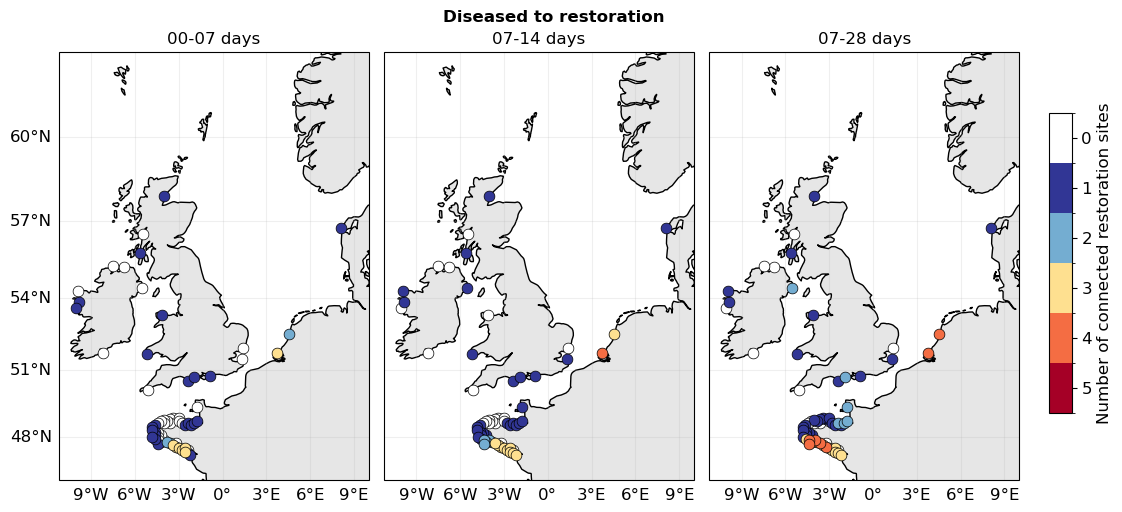

In [18]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(15, 6))

scenarios = [
    (ds_conn_07, "dss_count_hex0", "00-07 days"),
    (ds_conn_14, "dss_count_hex0", "07-14 days"),
    (ds_conn_28, "dss_count_hex0", "07-28 days"),
    (ds_conn_07, "aqc_count_hex0", "00-07 days"),
    (ds_conn_14, "aqc_count_hex0", "07-14 days"),
    (ds_conn_28, "aqc_count_hex0", "07-28 days"),
]

bins = [0, 1, 2, 3, 4, 5, 6]
colors = ['#ffffff','#313695','#74add1','#fee090', '#f46d43', '#a50026']

scatter_for_cbar = None
nrows, ncols = 1, 3  # <-- one row, three columns

for idx, (ax, (ds, source_var, label)) in enumerate(zip(axes.flat, scenarios[:3])):
    connected_counts = get_connected_counts(
        ds, source_var, "hex1", ["month", "year"], filter_var="rst_count_hex1", filter_val=0)
    known_sites = get_known_sites(ds, source_var)
    connected_counts_clean = connected_counts.to_dataset(name="num_connected_rst").to_pandas()
    plot_df = known_sites.join(connected_counts_clean[["num_connected_rst"]], how="inner").dropna(subset=["num_connected_rst"])
    scatter = plot_connected_sites(plot_df, "lon_hex0", "lat_hex0", "num_connected_rst", bins, colors, ax=ax)
    ax.set_title(label)
    dummy_x = np.zeros(len(bins) - 1)
    dummy_y = np.zeros(len(bins) - 1)
    dummy_vals = np.array(bins[:-1])

    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
    scatter_for_cbar = axes.flat[0].scatter(dummy_x, dummy_y, c=dummy_vals, cmap=cmap, norm=norm, s=0)

fig.text(0.55, 0.91, "Diseased to restoration", va='center', ha='center', fontsize=12, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    row = idx // ncols
    col = idx % ncols
    gl = ax.gridlines(draw_labels=True, zorder=10, alpha=0.2)
    gl.xlocator = MultipleLocator(3)
    gl.ylocator = MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.bottom_labels = True
    gl.top_labels = False
    gl.left_labels = (col == 0)
    gl.right_labels = False

cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
cbar = fig.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='vertical')

bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
cbar.set_ticks(bin_centers)
cbar.set_ticklabels([str(bins[i]) for i in range(len(bins)-1)])
cbar.ax.tick_params(labelsize=12)
cbar.ax.invert_yaxis()
cbar.set_label("Number of connected restoration sites", fontsize=12)

fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
plt.show()



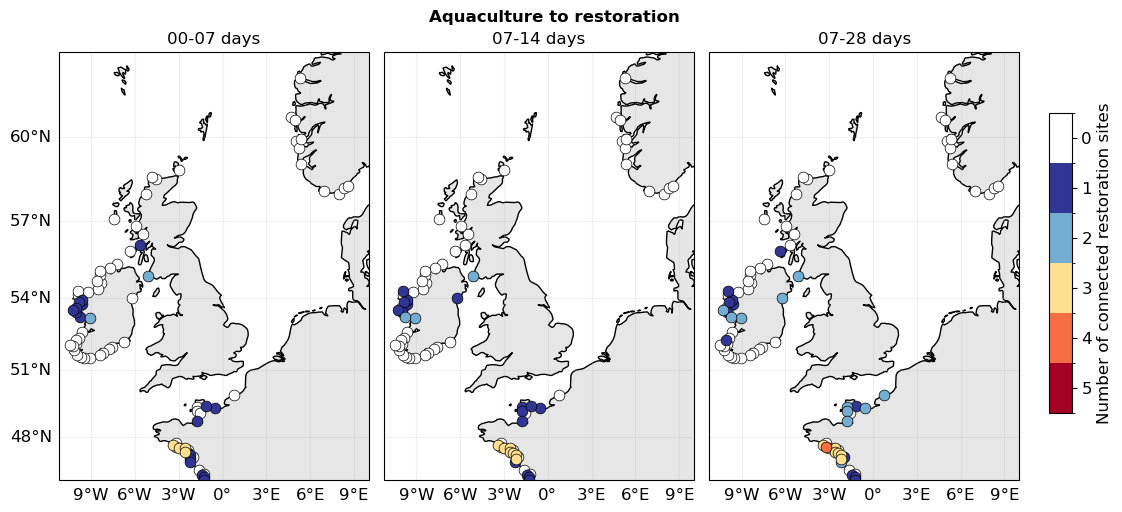

In [19]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(15, 6))

scatter_for_cbar = None
nrows, ncols = 1, 3  # <-- one row, three columns

for idx, (ax, (ds, source_var, label)) in enumerate(zip(axes.flat, scenarios[3:])):
    connected_counts = get_connected_counts(
        ds, source_var, "hex1", ["month", "year"], filter_var="rst_count_hex1", filter_val=0)
    known_sites = get_known_sites(ds, source_var)
    connected_counts_clean = connected_counts.to_dataset(name="num_connected_rst").to_pandas()
    plot_df = known_sites.join(connected_counts_clean[["num_connected_rst"]], how="inner").dropna(subset=["num_connected_rst"])
    scatter = plot_connected_sites(plot_df, "lon_hex0", "lat_hex0", "num_connected_rst", bins, colors, ax=ax)
    ax.set_title(label)
    dummy_x = np.zeros(len(bins) - 1)
    dummy_y = np.zeros(len(bins) - 1)
    dummy_vals = np.array(bins[:-1])

    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
    scatter_for_cbar = axes.flat[0].scatter(dummy_x, dummy_y, c=dummy_vals, cmap=cmap, norm=norm, s=0)

fig.text(0.55, 0.91, "Aquaculture to restoration", va='center', ha='center', fontsize=12, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    row = idx // ncols
    col = idx % ncols
    gl = ax.gridlines(draw_labels=True, zorder=10, alpha=0.2)
    gl.xlocator = MultipleLocator(3)
    gl.ylocator = MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.bottom_labels = True
    gl.top_labels = False
    gl.left_labels = (col == 0)
    gl.right_labels = False

cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
cbar = fig.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='vertical')

bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
cbar.set_ticks(bin_centers)
cbar.set_ticklabels([str(bins[i]) for i in range(len(bins)-1)])
cbar.ax.tick_params(labelsize=12)
cbar.ax.invert_yaxis()
cbar.set_label("Number of connected restoration sites", fontsize=12)

fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
plt.show()



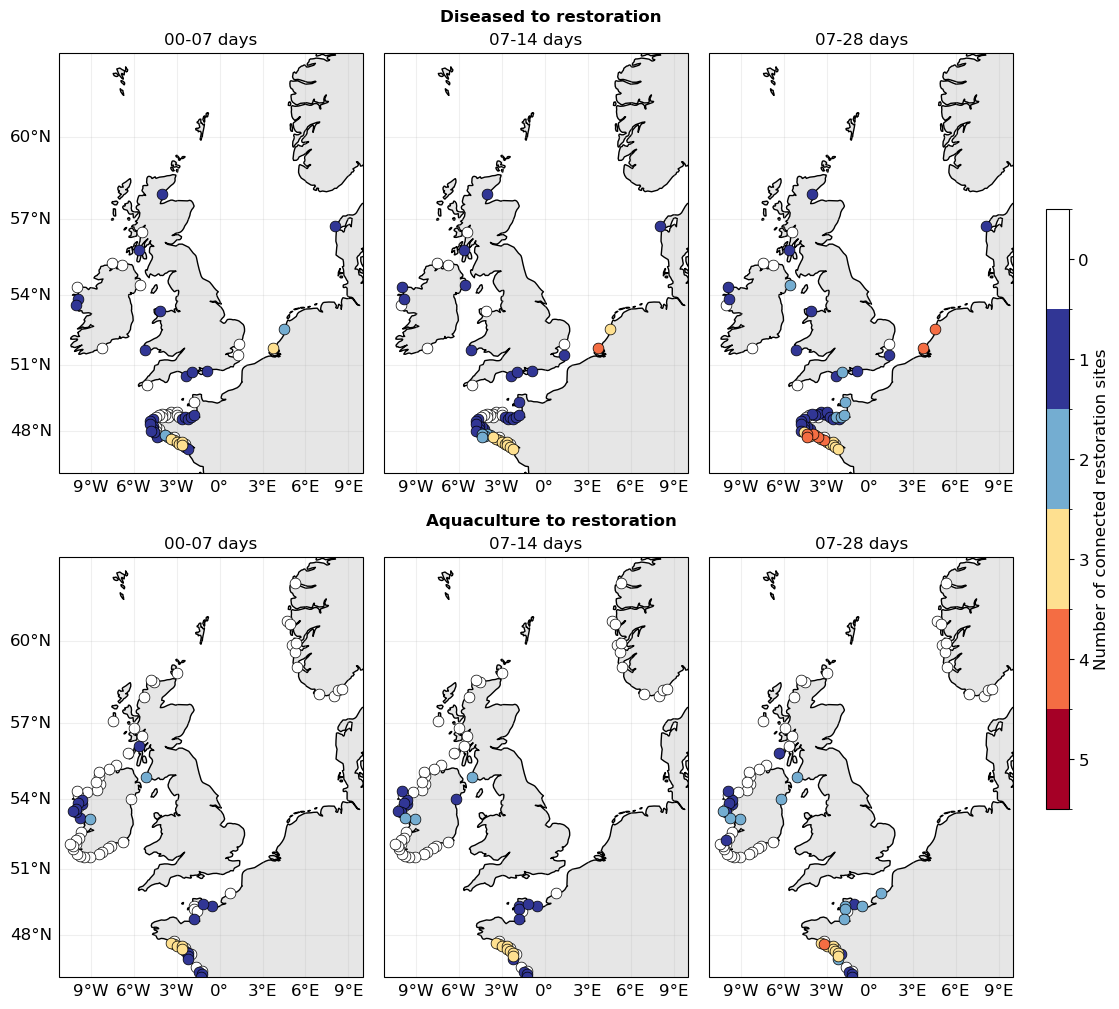

In [11]:
fig, axes = plt.subplots(2, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(15, 12))
scenarios = [
    (ds_conn_07, "dss_count_hex0", "00-07 days"),
    (ds_conn_14, "dss_count_hex0", "07-14 days"),
    (ds_conn_28, "dss_count_hex0", "07-28 days"),
    (ds_conn_07, "aqc_count_hex0", "00-07 days"),
    (ds_conn_14, "aqc_count_hex0", "07-14 days"),
    (ds_conn_28, "aqc_count_hex0", "07-28 days"),
]

bins = [0, 1, 2, 3, 4, 5, 6]
colors = ['#ffffff','#313695','#74add1','#fee090', '#f46d43', '#a50026']

scatter_for_cbar = None
nrows, ncols = axes.shape

for idx, (ax, (ds, source_var, label)) in enumerate(zip(axes.flat, scenarios)):
    connected_counts = get_connected_counts(
        ds, source_var, "hex1", ["month", "year"], filter_var="rst_count_hex1", filter_val=0)
    known_sites = get_known_sites(ds, source_var)
    connected_counts_clean = connected_counts.to_dataset(name="num_connected_rst").to_pandas()
    plot_df = known_sites.join(connected_counts_clean[["num_connected_rst"]], how="inner").dropna(subset=["num_connected_rst"])
    scatter = plot_connected_sites(plot_df, "lon_hex0", "lat_hex0", "num_connected_rst", bins, colors, ax=ax)
    ax.set_title(label)
    dummy_x = np.zeros(len(bins) - 1)
    dummy_y = np.zeros(len(bins) - 1)
    dummy_vals = np.array(bins[:-1])

    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
    scatter_for_cbar = axes.flat[0].scatter(dummy_x, dummy_y, c=dummy_vals, cmap=cmap, norm=norm, s=0)

fig.text(0.55, 0.91, "Diseased to restoration", va='center', ha='center', fontsize=12, fontweight='bold')
fig.text(0.55, 0.49, "Aquaculture to restoration", va='center', ha='center', fontsize=12, fontweight='bold')


# Add gridlines and set labels only after plotting
for idx, ax in enumerate(axes.flat):
    row = idx // ncols
    col = idx % ncols
    gl = ax.gridlines(draw_labels=True, zorder=10, alpha=0.2)
    gl.xlocator = MultipleLocator(3)
    gl.ylocator = MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.bottom_labels = True
    gl.top_labels = False
    gl.left_labels = (col == 0)
    gl.right_labels = False

# Colorbar
cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
cbar = fig.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='vertical')

# Set ticks at bin centers
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
cbar.set_ticks(bin_centers)
cbar.set_ticklabels([str(bins[i]) for i in range(len(bins)-1)])
cbar.ax.tick_params(labelsize=12)
cbar.ax.invert_yaxis()
cbar.set_label("Number of connected restoration sites", fontsize=12)

fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
plt.show()

## Highly connected to habitable

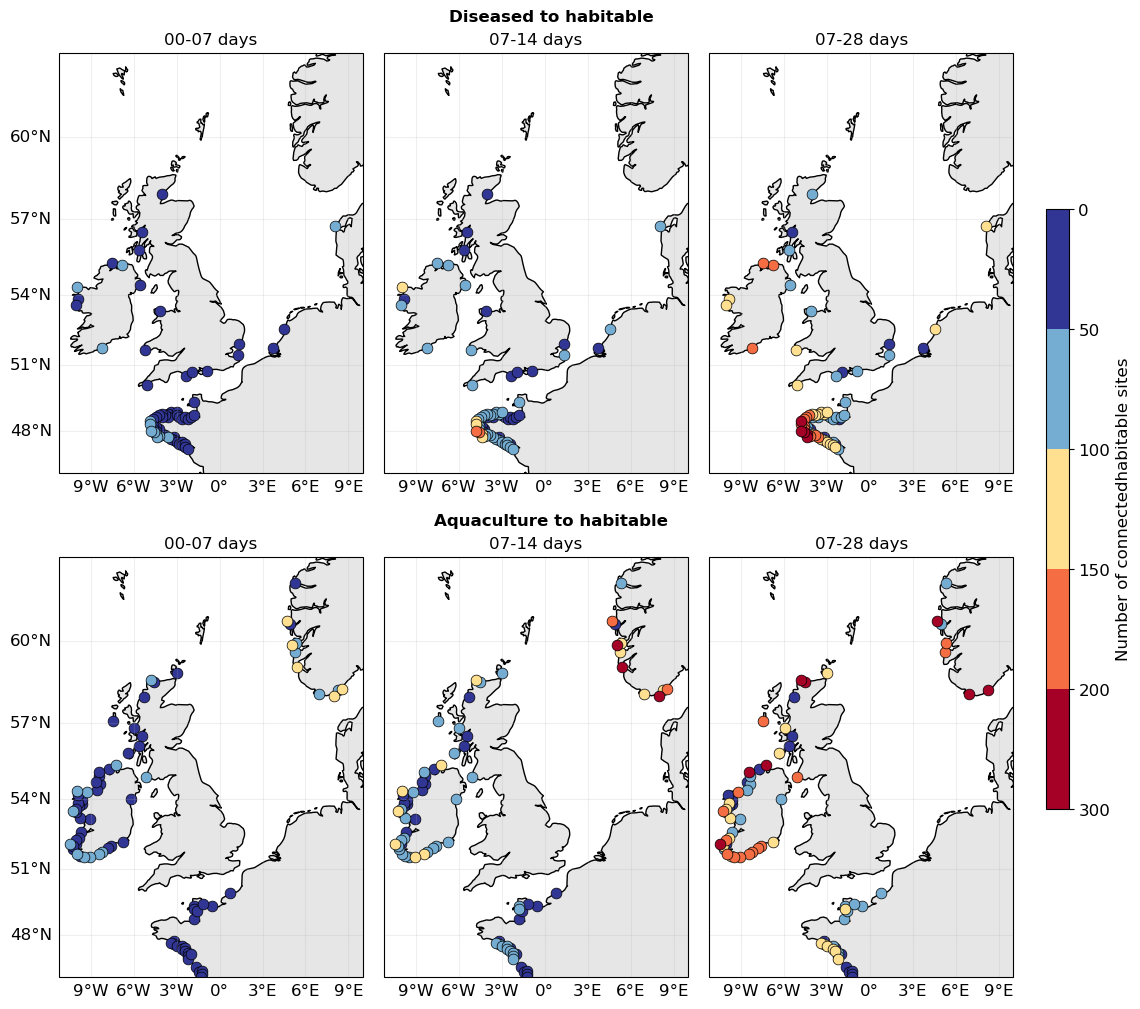

In [12]:
fig, axes = plt.subplots(2, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(15, 12))
scenarios = [
    (ds_conn_07, "dss_count_hex0", "00-07 days"),
    (ds_conn_14, "dss_count_hex0", "07-14 days"),
    (ds_conn_28, "dss_count_hex0", "07-28 days"),
    (ds_conn_07, "aqc_count_hex0", "00-07 days"),
    (ds_conn_14, "aqc_count_hex0", "07-14 days"),
    (ds_conn_28, "aqc_count_hex0", "07-28 days"),
]
bins = [0, 50, 100, 150, 200, 300]
colors = ['#313695', '#74add1', '#fee090', '#f46d43', '#a50026']

scatter_for_cbar = None
nrows, ncols = axes.shape
for idx, (ax, (ds, source_var, label)) in enumerate(zip(axes.flat, scenarios)):
    connected_counts = get_connected_counts(ds, source_var, "hex1", ["month", "year"])
    known_sites = get_known_sites(ds, source_var)
    connected_counts_clean = connected_counts.to_dataset(name="num_connected_hab").to_pandas()
    plot_df = known_sites.join(connected_counts_clean[["num_connected_hab"]], how="inner").dropna(subset=["num_connected_hab"])
    plot_connected_sites(plot_df, "lon_hex0", "lat_hex0", "num_connected_hab", bins, colors, ax=ax)
    ax.set_title(label)
    # Prepare a dummy scatter for colorbar
    if scatter_for_cbar is None and not plot_df.empty:
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
        scatter_for_cbar = ax.scatter([0], [0], c=[bins[0]], cmap=cmap, norm=norm)

fig.text(0.55, 0.91, "Diseased to habitable", va='center', ha='center', fontsize=12, fontweight='bold')
fig.text(0.55, 0.49, "Aquaculture to habitable", va='center', ha='center', fontsize=12, fontweight='bold')

# Add gridlines and set labels only after plotting
for idx, ax in enumerate(axes.flat):
    row = idx // ncols
    col = idx % ncols
    gl = ax.gridlines(draw_labels=True, zorder=10, alpha=0.2)
    gl.xlocator = MultipleLocator(3)
    gl.ylocator = MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.bottom_labels = True
    gl.top_labels = False
    gl.left_labels = (col == 0)
    gl.right_labels = False
    
# Colorbar
cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
cbar = fig.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='vertical', ticks=bins)
cbar.ax.tick_params(labelsize=12)
cbar.ax.invert_yaxis()
cbar.set_label("Number of connectedhabitable sites", fontsize=12)

fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
plt.show()


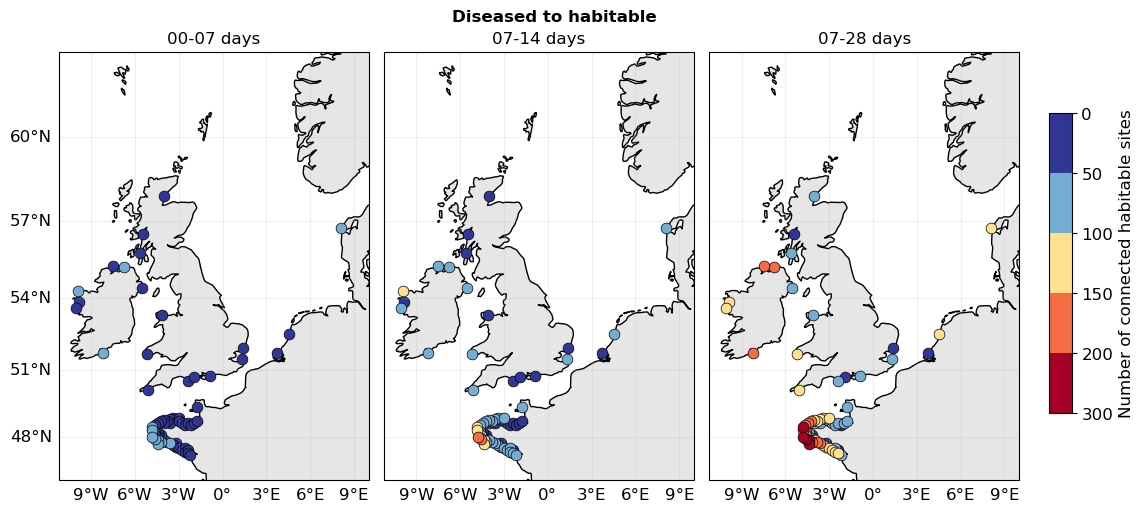

In [13]:
# ...existing code...
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(15, 6))
scenarios = [
    (ds_conn_07, "dss_count_hex0", "00-07 days"),
    (ds_conn_14, "dss_count_hex0", "07-14 days"),
    (ds_conn_28, "dss_count_hex0", "07-28 days"),
]
bins = [0, 50, 100, 150, 200, 300]
colors = ['#313695', '#74add1', '#fee090', '#f46d43', '#a50026']

scatter_for_cbar = None
ncols = len(axes)
nrows = 1
for idx, (ax, (ds, source_var, label)) in enumerate(zip(axes.flat, scenarios)):
    connected_counts = get_connected_counts(ds, source_var, "hex1", ["month", "year"])
    known_sites = get_known_sites(ds, source_var)
    connected_counts_clean = connected_counts.to_dataset(name="num_connected_hab").to_pandas()
    plot_df = known_sites.join(connected_counts_clean[["num_connected_hab"]], how="inner").dropna(subset=["num_connected_hab"])
    plot_connected_sites(plot_df, "lon_hex0", "lat_hex0", "num_connected_hab", bins, colors, ax=ax)
    ax.set_title(label)
    if scatter_for_cbar is None and not plot_df.empty:
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
        scatter_for_cbar = ax.scatter([0], [0], c=[bins[0]], cmap=cmap, norm=norm)

fig.text(0.55, 0.91, "Diseased to habitable", va='center', ha='center', fontsize=12, fontweight='bold')

# Add gridlines and set labels only after plotting
for idx, ax in enumerate(axes.flat):
    col = idx % ncols
    gl = ax.gridlines(draw_labels=True, zorder=10, alpha=0.2)
    gl.xlocator = MultipleLocator(3)
    gl.ylocator = MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.bottom_labels = True
    gl.top_labels = False
    gl.left_labels = (col == 0)
    gl.right_labels = False

# Colorbar
cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
cbar = fig.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='vertical', ticks=bins)
cbar.ax.tick_params(labelsize=12)
cbar.ax.invert_yaxis()
cbar.set_label("Number of connected habitable sites", fontsize=12)

fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
plt.show()

### HIghly connected to historic

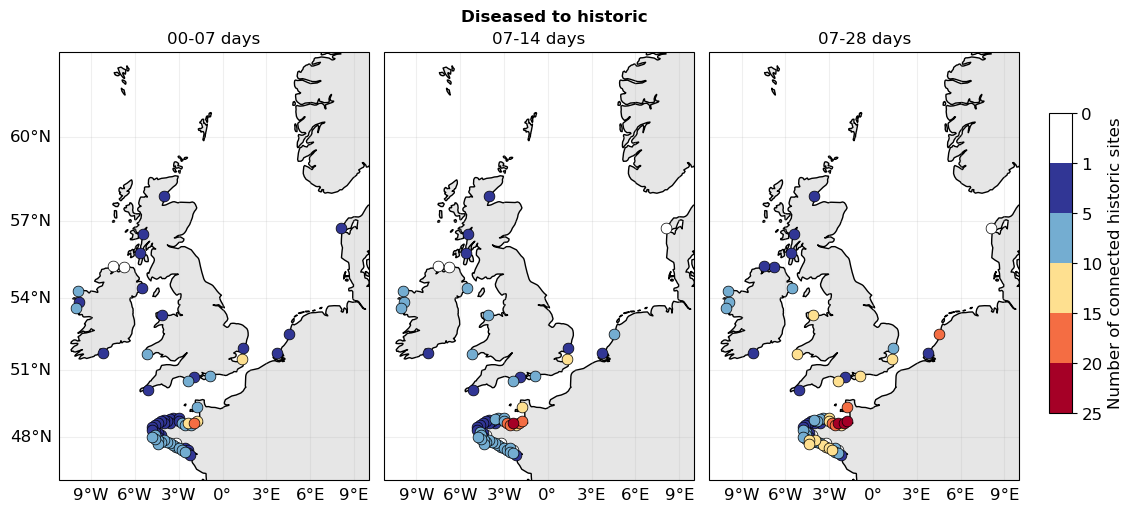

In [55]:
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(15, 6))

scenarios = [
    (ds_conn_07, "dss_count_hex0", "00-07 days"),
    (ds_conn_14, "dss_count_hex0", "07-14 days"),
    (ds_conn_28, "dss_count_hex0", "07-28 days"),
]
bins = [0, 1, 5, 10, 15, 20, 25]
colors = ['white','#313695', '#74add1', '#fee090', '#f46d43', '#a50026']

scatter_for_cbar = None
nrows, ncols = 1, 3

for idx, (ax, (ds, source_var, label)) in enumerate(zip(axes.flat, scenarios)):
    connected_counts = get_connected_counts(
        ds, source_var, "hex1", ["month", "year"], filter_var="his_count_hex1", filter_val=0
    )
    known_sites = get_known_sites(ds, source_var)
    connected_counts_clean = connected_counts.to_dataset(name="num_connected_hab").to_pandas()
    plot_df = known_sites.join(connected_counts_clean[["num_connected_hab"]], how="inner").dropna(subset=["num_connected_hab"])
    plot_connected_sites(plot_df, "lon_hex0", "lat_hex0", "num_connected_hab", bins, colors, ax=ax)
    ax.set_title(label)
    if scatter_for_cbar is None and not plot_df.empty:
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bins, ncolors=len(colors))
        scatter_for_cbar = ax.scatter([0], [0], c=[bins[0]], cmap=cmap, norm=norm)

fig.text(0.55, 0.91, "Diseased to historic", va='center', ha='center', fontsize=12, fontweight='bold')

# Add gridlines and set labels only after plotting
for idx, ax in enumerate(axes.flat):
    col = idx % ncols
    gl = ax.gridlines(draw_labels=True, zorder=10, alpha=0.2)
    gl.xlocator = MultipleLocator(3)
    gl.ylocator = MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.bottom_labels = True
    gl.top_labels = False
    gl.left_labels = (col == 0)
    gl.right_labels = False

# Colorbar
cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
cbar = fig.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='vertical', ticks=bins)
cbar.ax.tick_params(labelsize=12)
cbar.ax.invert_yaxis()
cbar.set_label("Number of connected historic sites", fontsize=12)

fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
plt.show()

# Old

## Highly connected diseased to habitable 

### Diseased to habitable AVERAGE 00-07

In [ ]:
dss_to_habitable_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_07.depth_median_hex0 < 85)
    | (ds_conn_07.pop_count_hex0 > 0)
    | (ds_conn_07.his_count_hex0 > 0)
    | (ds_conn_07.rst_count_hex0 > 0)
    | (ds_conn_07.aqc_count_hex0 > 0)
    | (ds_conn_07.dss_count_hex0 > 0)
    | (ds_conn_07.hly_count_hex0 > 0)
)

In [19]:
known_dss_sites = ds_conn_07.dss_count_hex0.where(ds_conn_07.dss_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [20]:
connected = (dss_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [21]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_dss_plot_df = known_dss_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_dss_plot_df = known_dss_plot_df.dropna(subset=["num_connected_hab"])

In [22]:
known_dss_plot_df.num_connected_hab.min()

3

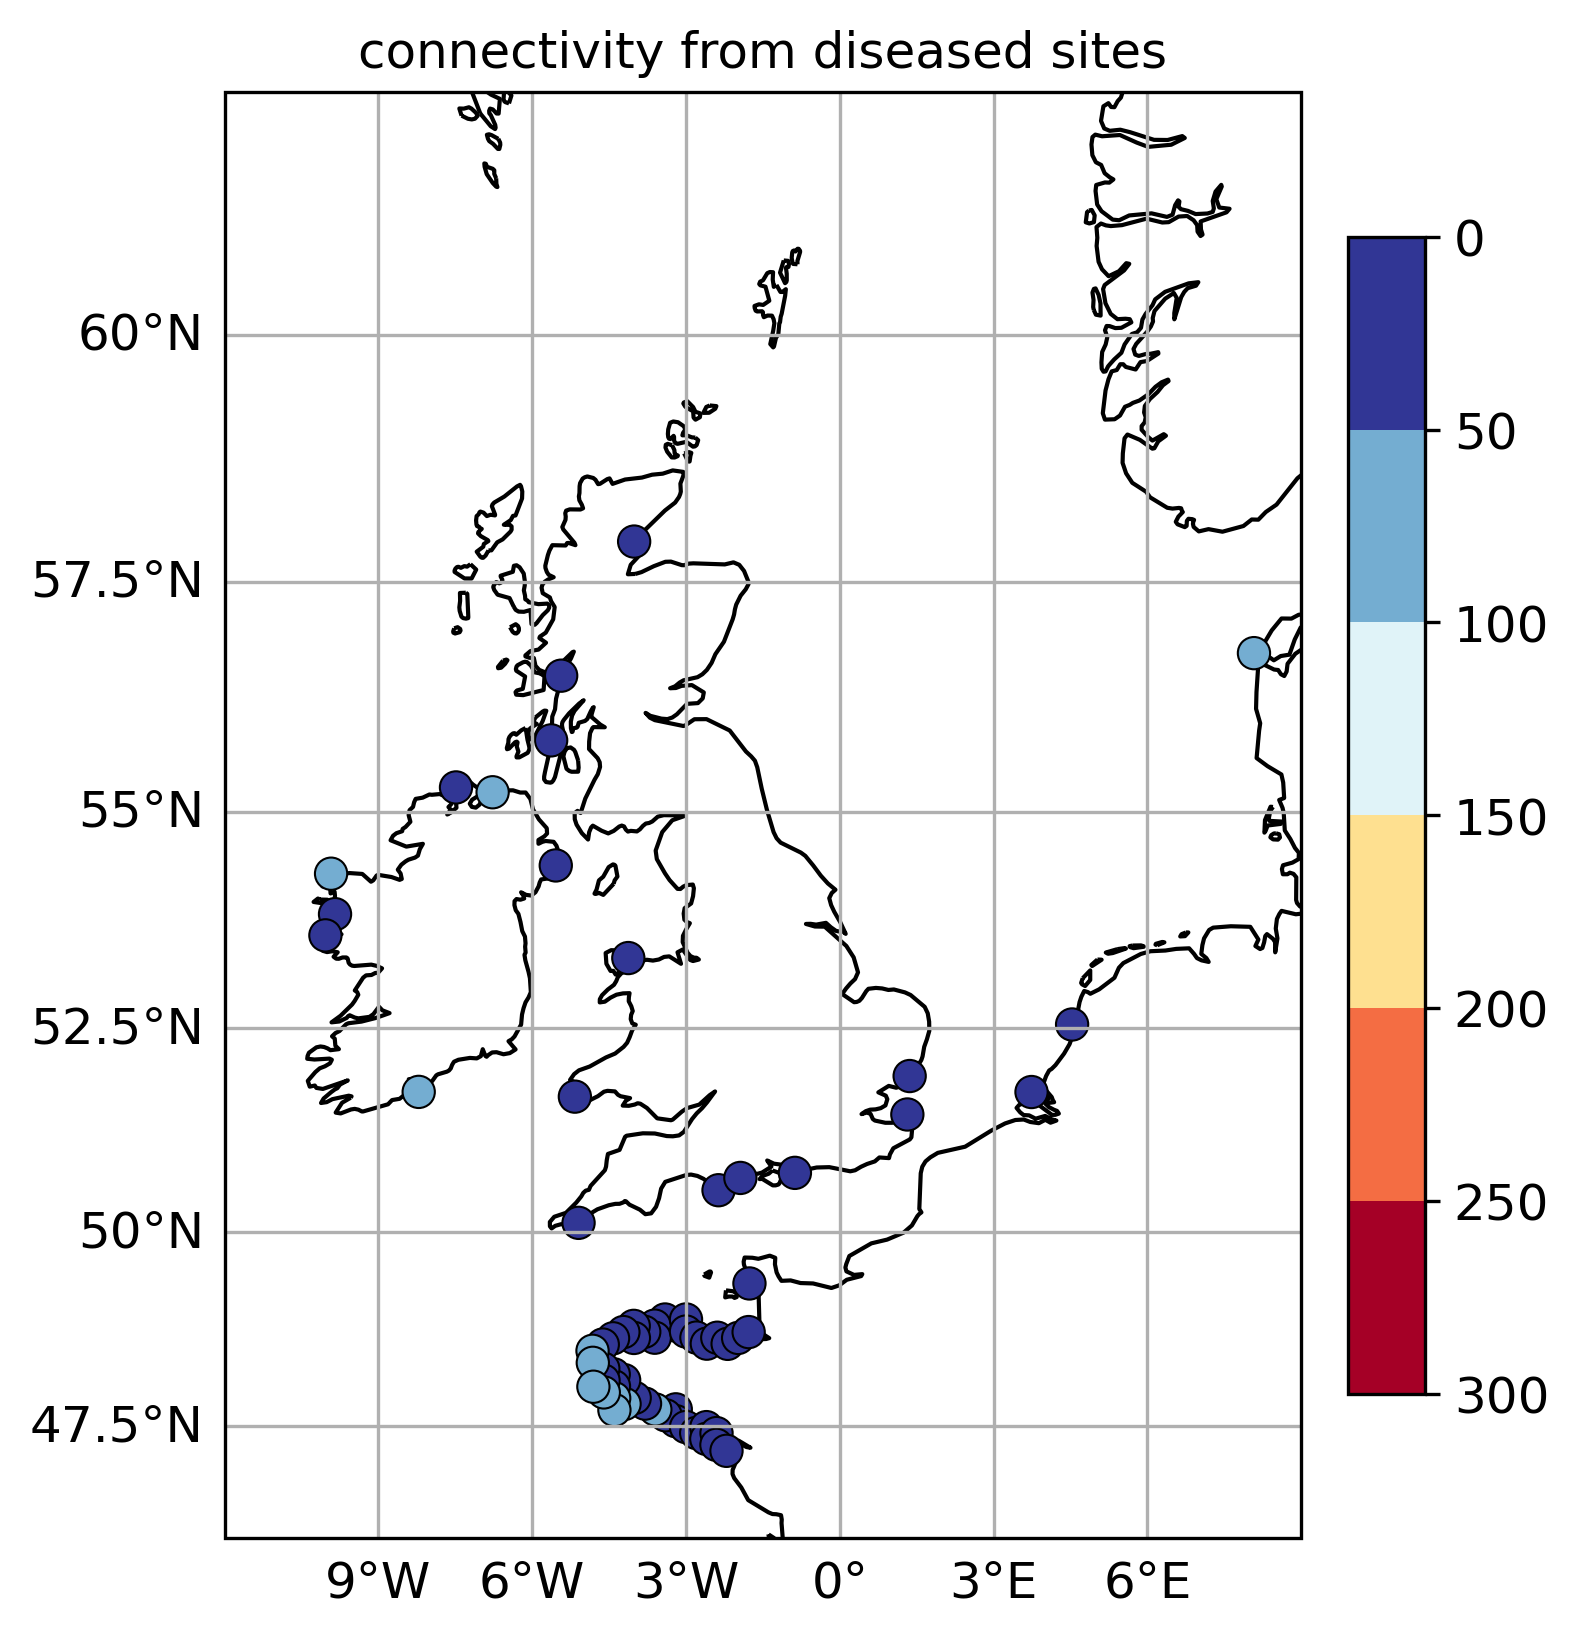

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_dss_plot_df["lon_hex0"], known_dss_plot_df["lat_hex0"],
    c=known_dss_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_dss_to_hab_05m_00-07.pdf")

### Diseased to habitable AVERAGE 07-14

In [ ]:
dss_to_habitable_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_14.depth_median_hex0 < 85)
    | (ds_conn_14.pop_count_hex0 > 0)
    | (ds_conn_14.his_count_hex0 > 0)
    | (ds_conn_14.rst_count_hex0 > 0)
    | (ds_conn_14.aqc_count_hex0 > 0)
    | (ds_conn_14.dss_count_hex0 > 0)
    | (ds_conn_14.hly_count_hex0 > 0)
)

In [27]:
known_dss_sites = ds_conn_14.dss_count_hex0.where(ds_conn_14.dss_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [28]:
connected = (dss_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [29]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_dss_plot_df = known_dss_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_dss_plot_df = known_dss_plot_df.dropna(subset=["num_connected_hab"])

In [30]:
known_dss_plot_df.num_connected_hab.max()

157

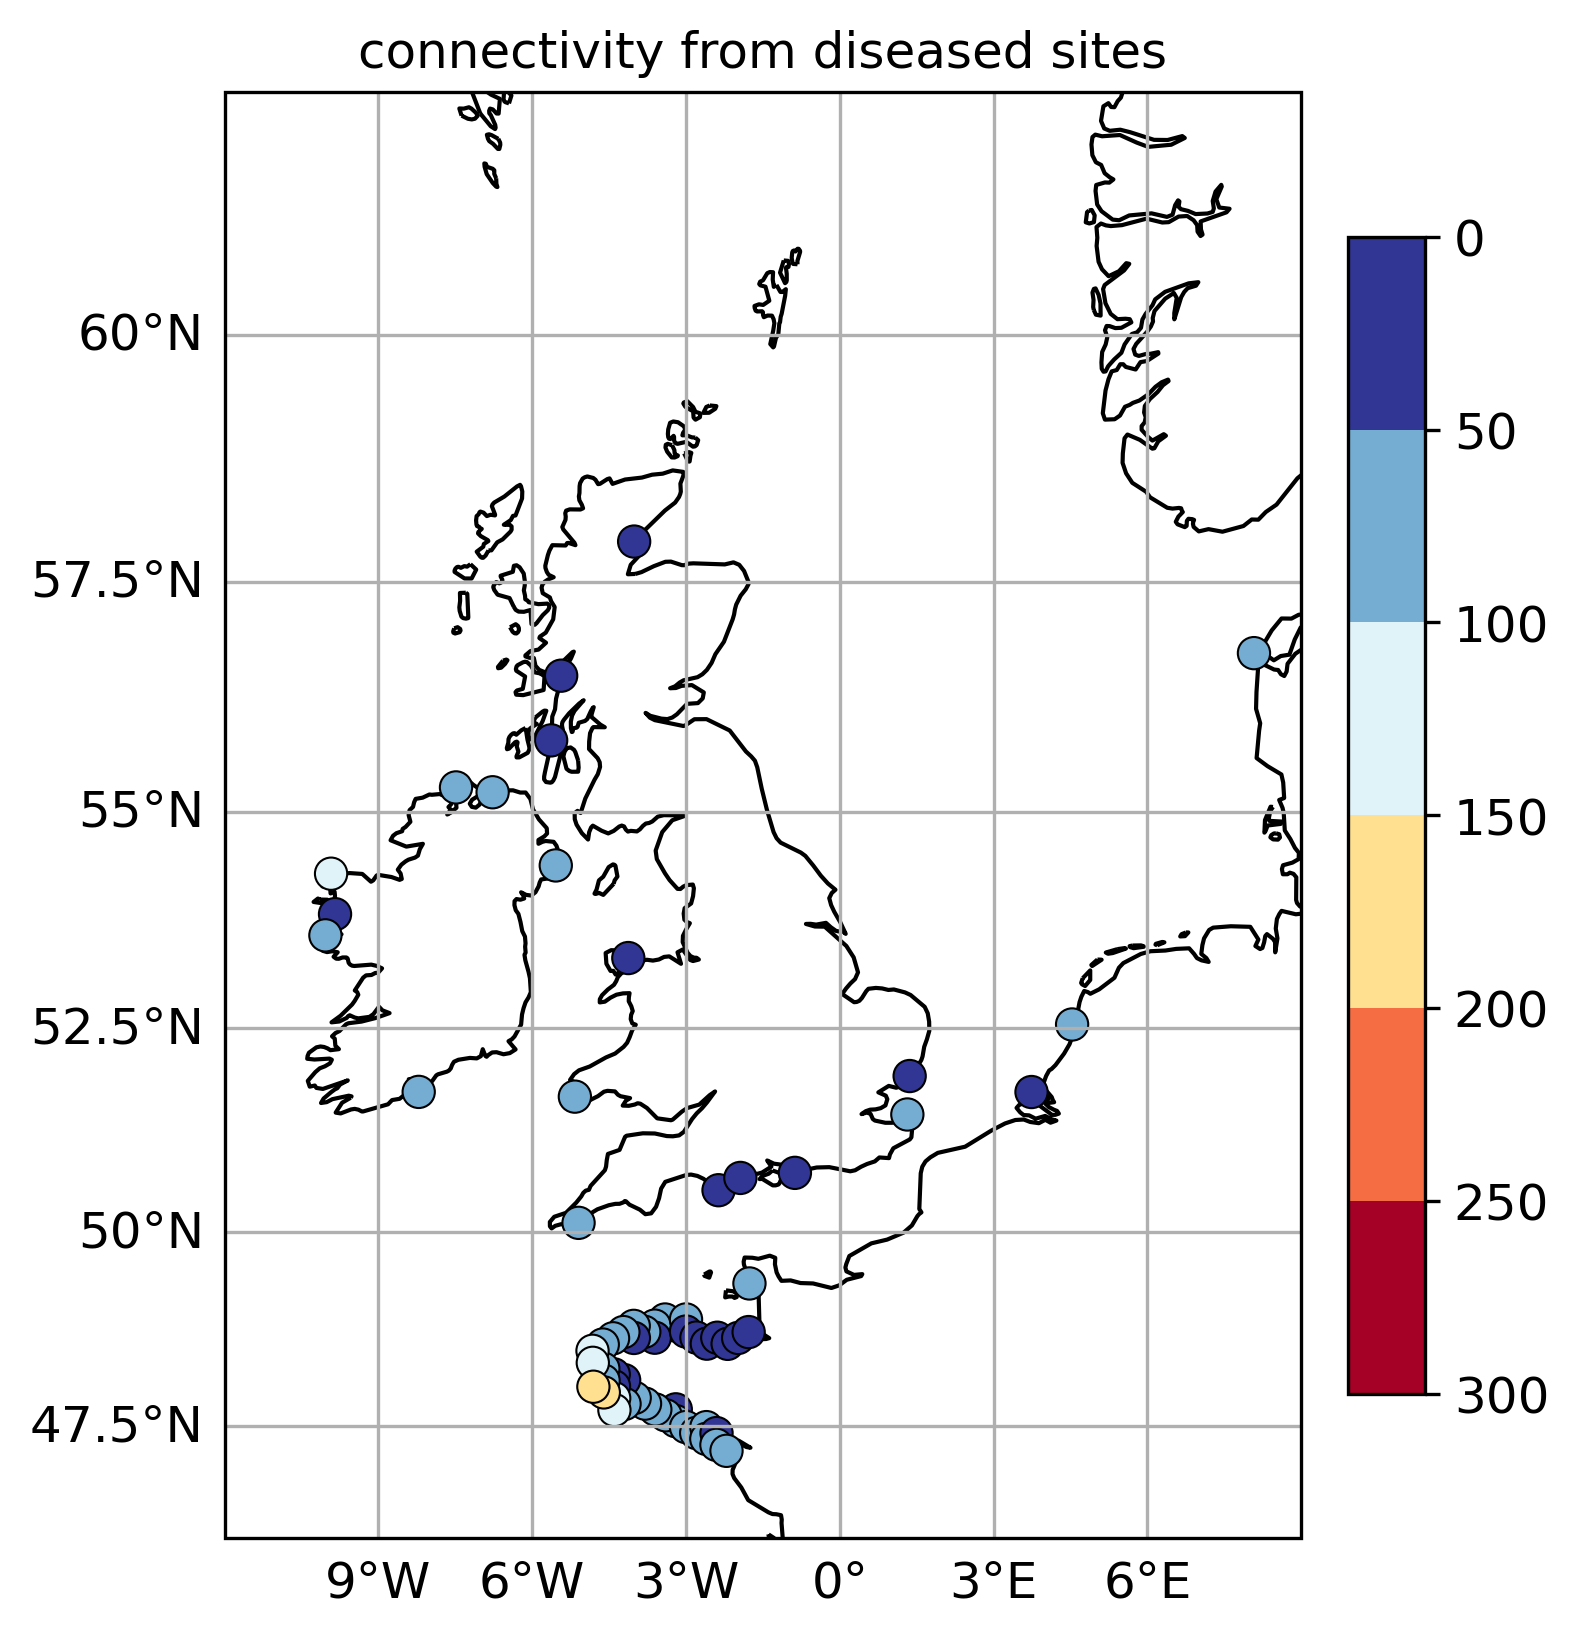

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]
cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_dss_plot_df["lon_hex0"], known_dss_plot_df["lat_hex0"],
    c=known_dss_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_dss_to_hab_05m_07-14.pdf")

### Diseased to habitable AVERAGE 07-28

In [ ]:
dss_to_habitable_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_28.depth_median_hex0 < 85)
    | (ds_conn_28.pop_count_hex0 > 0)
    | (ds_conn_28.his_count_hex0 > 0)
    | (ds_conn_28.rst_count_hex0 > 0)
    | (ds_conn_28.aqc_count_hex0 > 0)
    | (ds_conn_28.dss_count_hex0 > 0)
    | (ds_conn_28.hly_count_hex0 > 0)
)

In [33]:
known_dss_sites = ds_conn_28.dss_count_hex0.where(ds_conn_28.dss_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [34]:
known_rst_sites = ds_conn_28.rst_count_hex0.where(ds_conn_28.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [35]:
connected = (dss_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [36]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_dss_plot_df = known_dss_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_dss_plot_df = known_dss_plot_df.dropna(subset=["num_connected_hab"])

In [37]:
known_dss_plot_df.num_connected_hab.max()

301

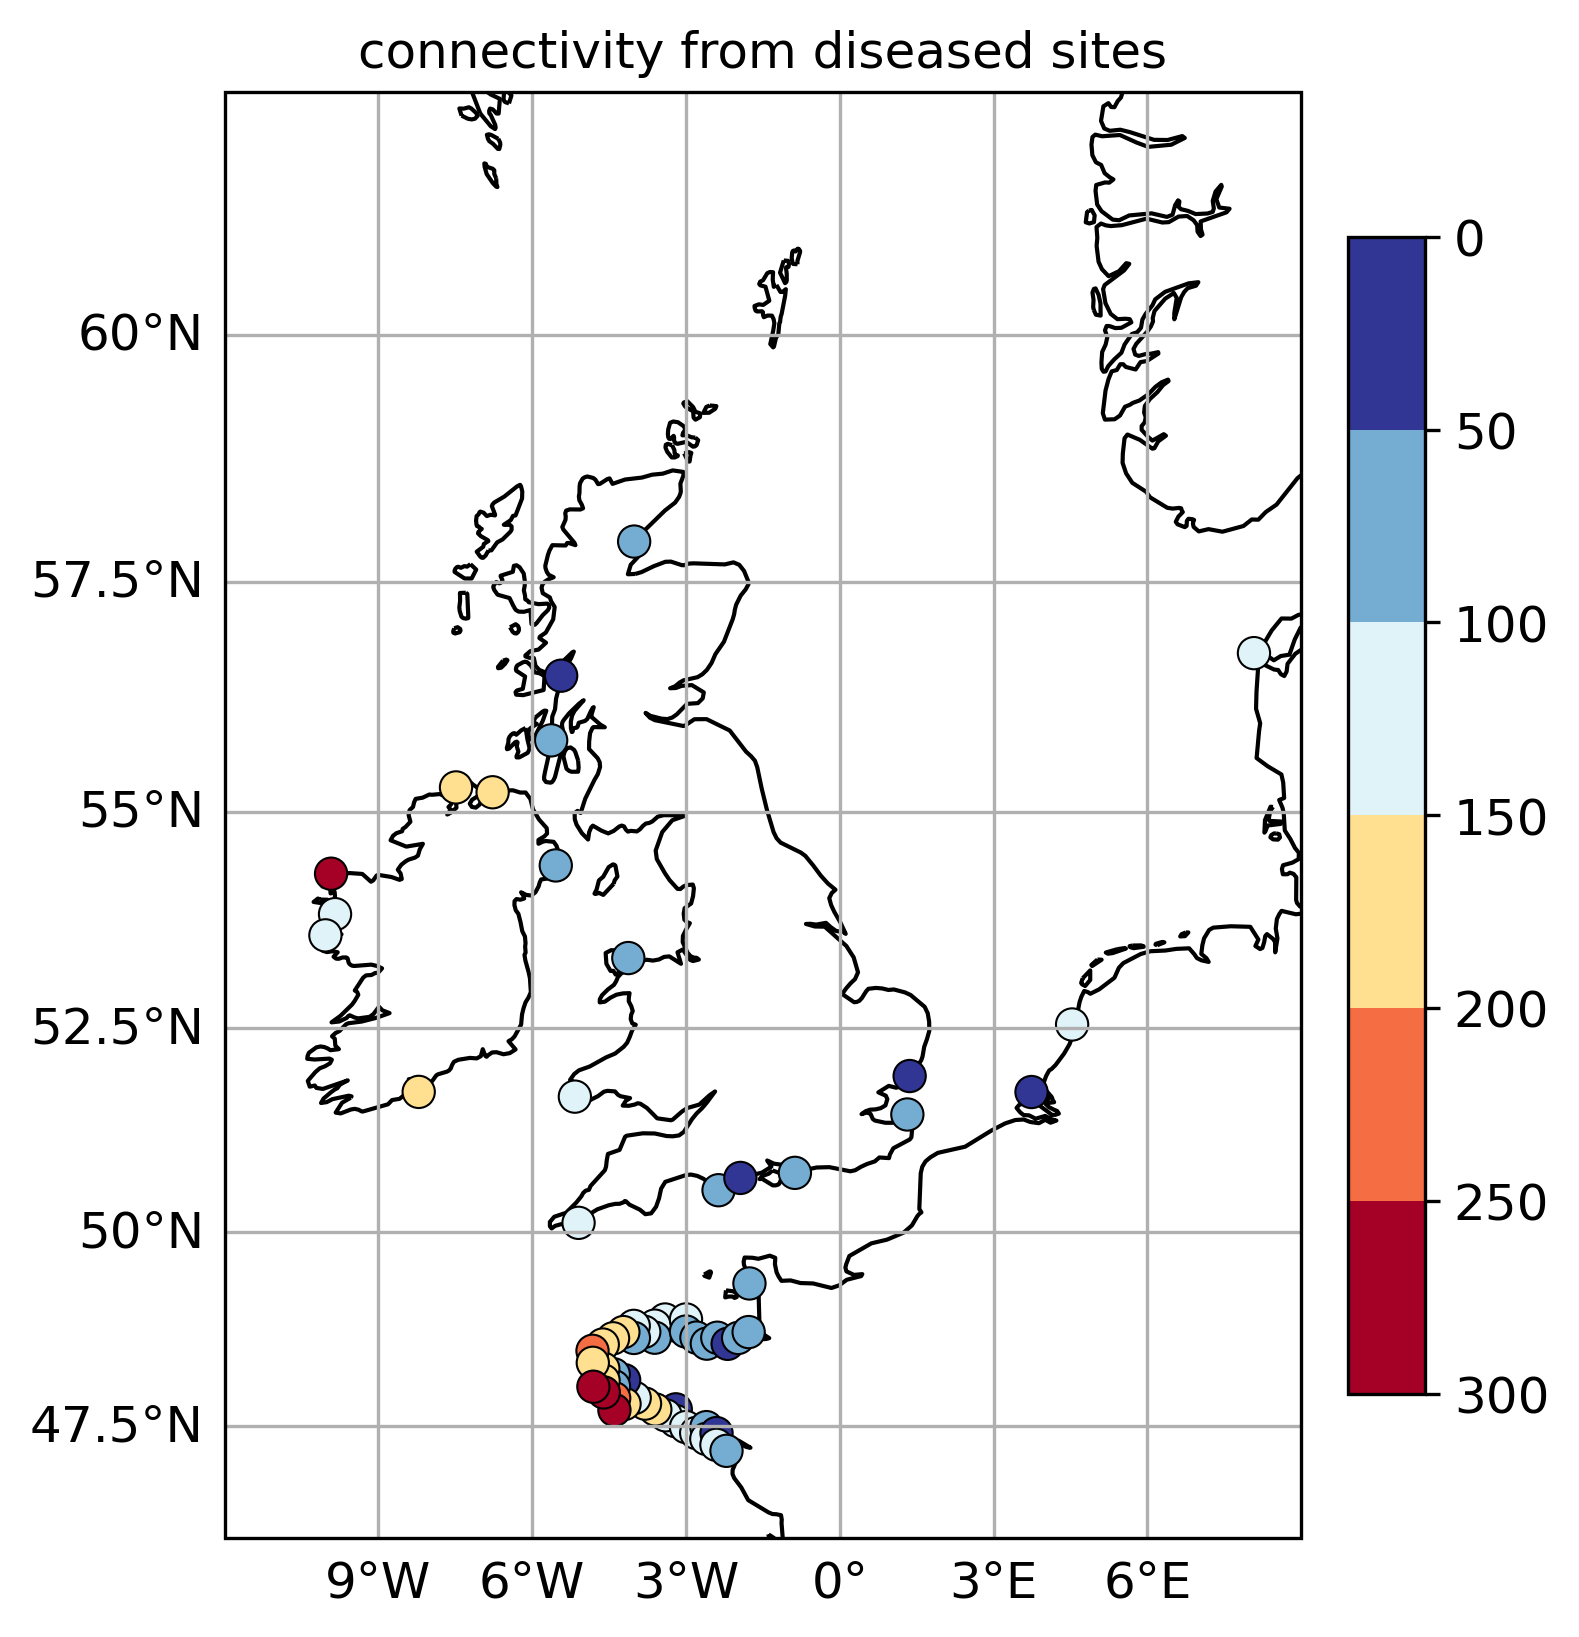

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_dss_plot_df["lon_hex0"], known_dss_plot_df["lat_hex0"],
    c=known_dss_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_dss_to_hab_05m_07-28.pdf")

## Highly connected aquaculture to habitable 

### Aquaculture to habitable AVERAGE 00-07

In [ ]:
aq_to_habitable_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_07.depth_median_hex0 < 85)
    | (ds_conn_07.pop_count_hex0 > 0)
    | (ds_conn_07.his_count_hex0 > 0)
    | (ds_conn_07.rst_count_hex0 > 0)
    | (ds_conn_07.aqc_count_hex0 > 0)
    | (ds_conn_07.dss_count_hex0 > 0)
    | (ds_conn_07.hly_count_hex0 > 0)
)

In [40]:
known_aq_sites = ds_conn_07.aqc_count_hex0.where(ds_conn_07.aqc_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [41]:
connected = (aq_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [42]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_aq_plot_df = known_aq_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_aq_plot_df = known_aq_plot_df.dropna(subset=["num_connected_hab"])

In [43]:
known_aq_plot_df.num_connected_hab.max()

144

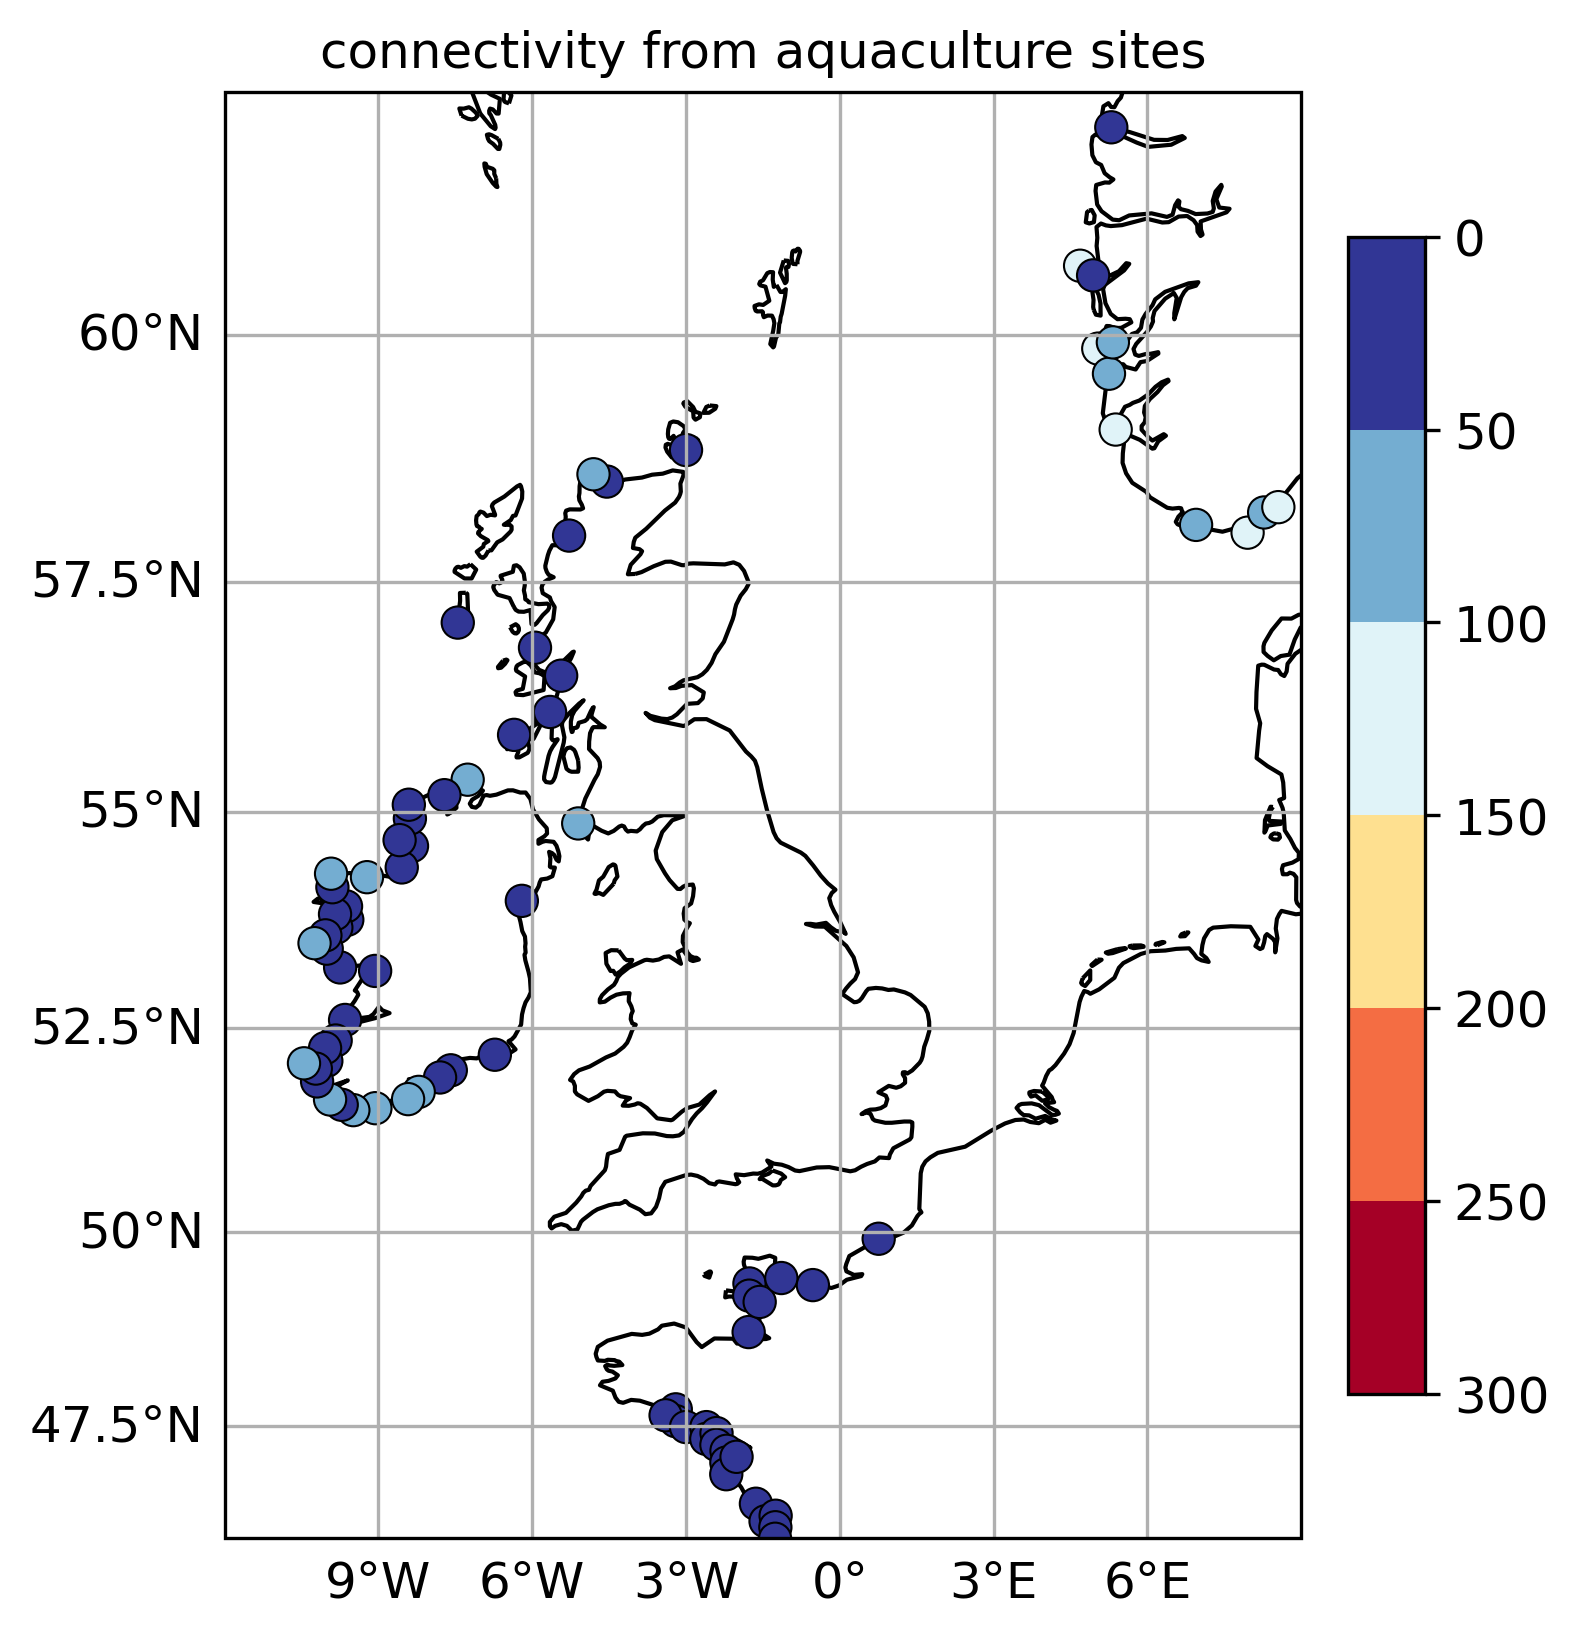

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_aq_plot_df["lon_hex0"], known_aq_plot_df["lat_hex0"],
    c=known_aq_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_aq_to_hab_05m_00-07.pdf")

### Aquaculture to habitable AVERAGE 07-14

In [ ]:
aq_to_habitable_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_14.depth_median_hex0 < 85)
    | (ds_conn_14.pop_count_hex0 > 0)
    | (ds_conn_14.his_count_hex0 > 0)
    | (ds_conn_14.rst_count_hex0 > 0)
    | (ds_conn_14.aqc_count_hex0 > 0)
    | (ds_conn_14.dss_count_hex0 > 0)
    | (ds_conn_14.hly_count_hex0 > 0)
)

In [46]:
known_aq_sites = ds_conn_14.aqc_count_hex0.where(ds_conn_14.aqc_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [47]:
connected = (aq_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [48]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_aq_plot_df = known_aq_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_aq_plot_df = known_aq_plot_df.dropna(subset=["num_connected_hab"])

In [49]:
known_aq_plot_df.num_connected_hab.max()

256

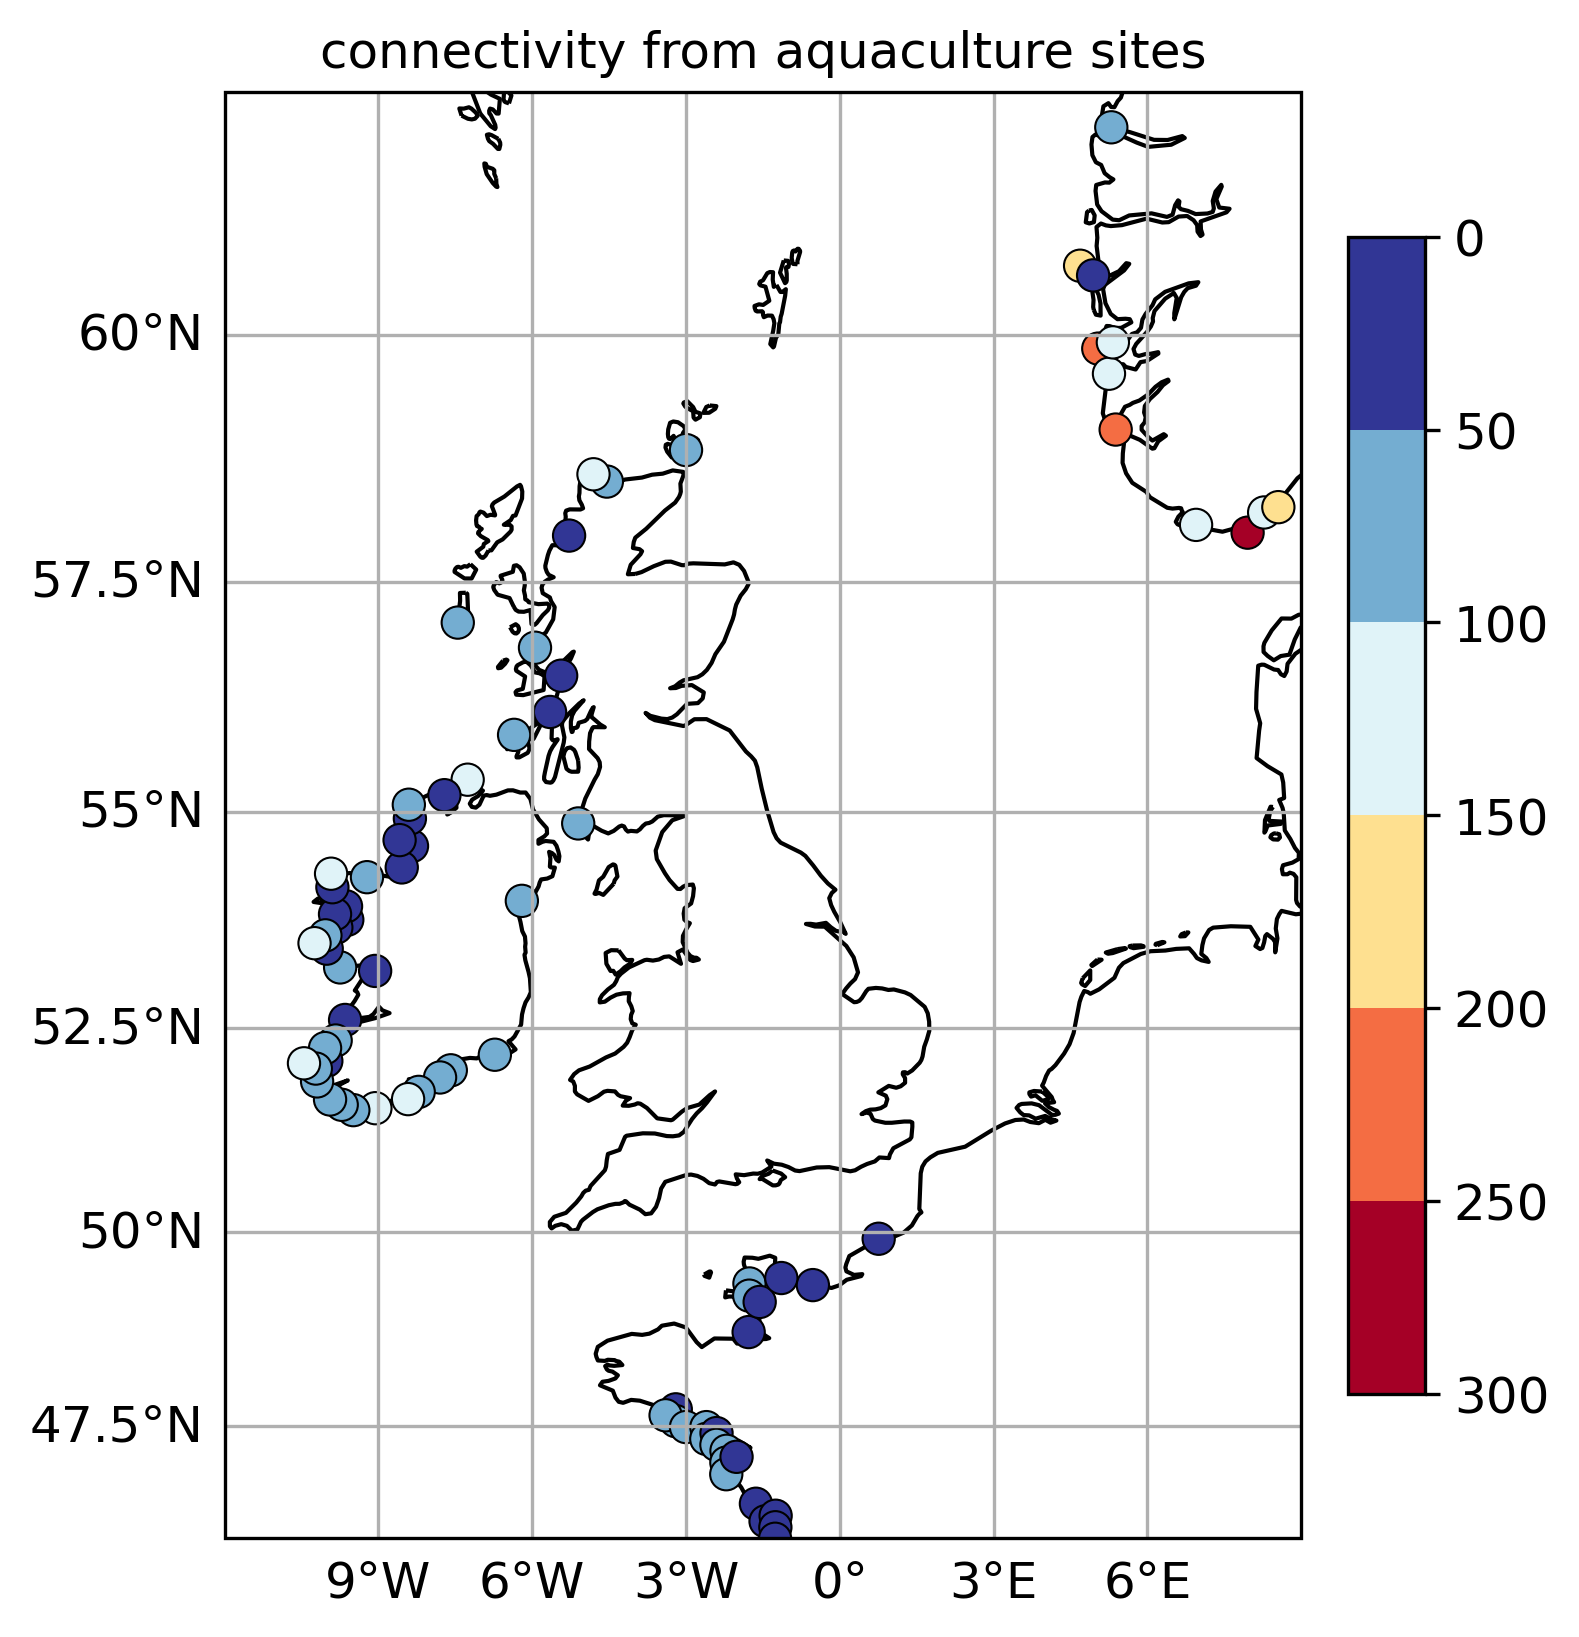

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_aq_plot_df["lon_hex0"], known_aq_plot_df["lat_hex0"],
    c=known_aq_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
##ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_aq_to_hab_05m_07-14.pdf")

### Aquaculture to habitable AVERAGE 07-28

In [ ]:
aq_to_habitable_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_28.depth_median_hex0 < 85)
    | (ds_conn_28.pop_count_hex0 > 0)
    | (ds_conn_28.his_count_hex0 > 0)
    | (ds_conn_28.rst_count_hex0 > 0)
    | (ds_conn_28.aqc_count_hex0 > 0)
    | (ds_conn_28.dss_count_hex0 > 0)
    | (ds_conn_28.hly_count_hex0 > 0)
)

In [52]:
known_aq_sites = ds_conn_28.aqc_count_hex0.where(ds_conn_28.aqc_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [53]:
connected = (aq_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [54]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_aq_plot_df = known_aq_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_aq_plot_df = known_aq_plot_df.dropna(subset=["num_connected_hab"])

In [55]:
known_aq_plot_df.num_connected_hab.max()

476

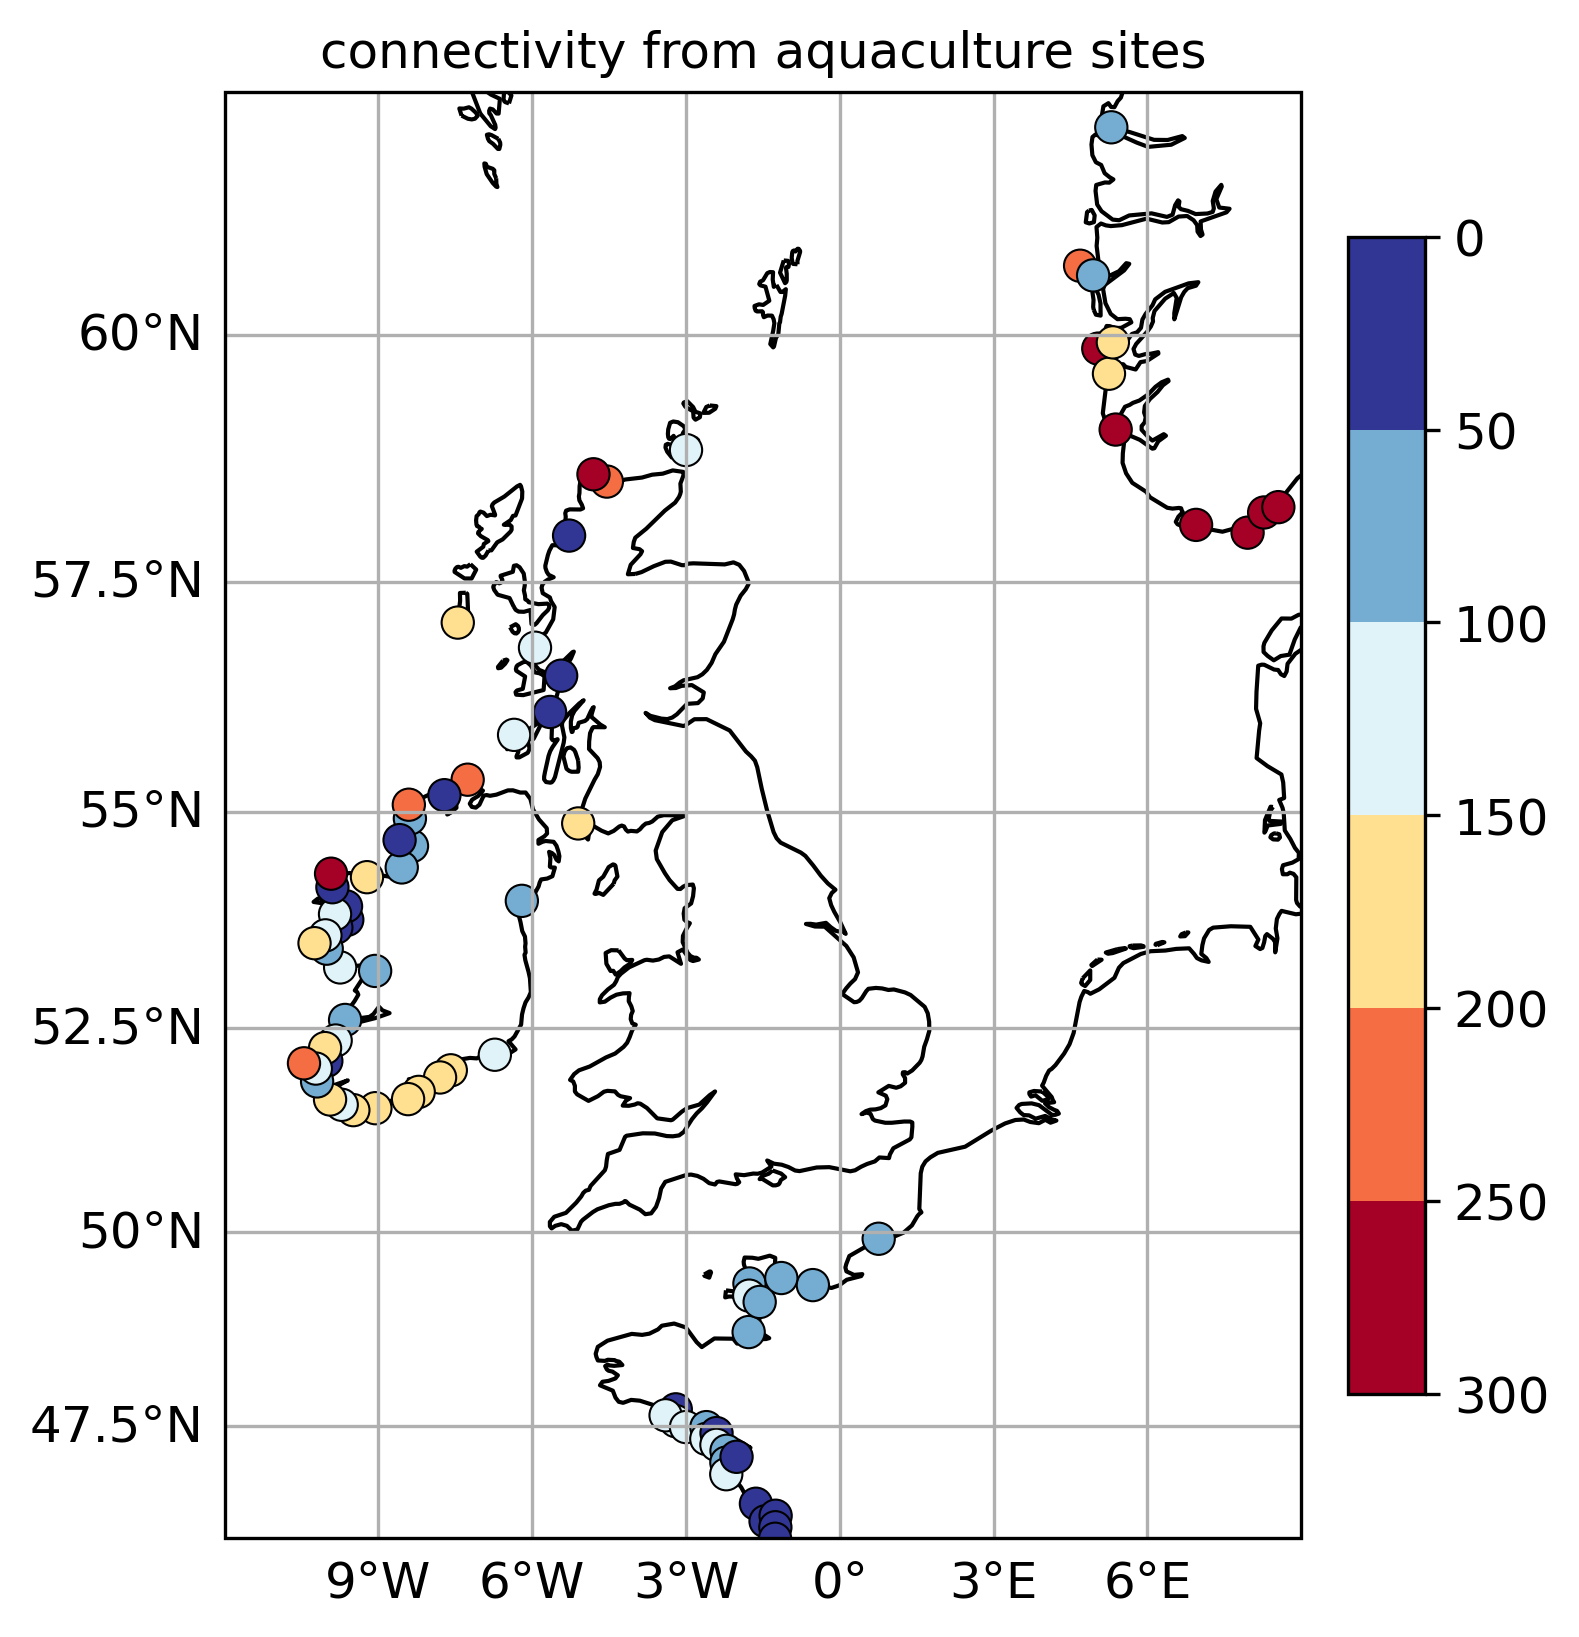

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_aq_plot_df["lon_hex0"], known_aq_plot_df["lat_hex0"],
    c=known_aq_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_aq_to_hab_05m_07-28.pdf")

## Highly connected historical to habitable 

### Historical to habitable AVERAGE 00-07

In [ ]:
his_to_habitable_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.his_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_07.depth_median_hex0 < 85)
    | (ds_conn_07.pop_count_hex0 > 0)
    | (ds_conn_07.his_count_hex0 > 0)
    | (ds_conn_07.rst_count_hex0 > 0)
    | (ds_conn_07.aqc_count_hex0 > 0)
    | (ds_conn_07.dss_count_hex0 > 0)
    | (ds_conn_07.hly_count_hex0 > 0)
)

In [58]:
known_his_sites = ds_conn_07.his_count_hex0.where(ds_conn_07.his_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [59]:
connected = (his_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [60]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_his_plot_df = known_his_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_his_plot_df = known_his_plot_df.dropna(subset=["num_connected_hab"])

In [61]:
known_his_plot_df.num_connected_hab.max()

152

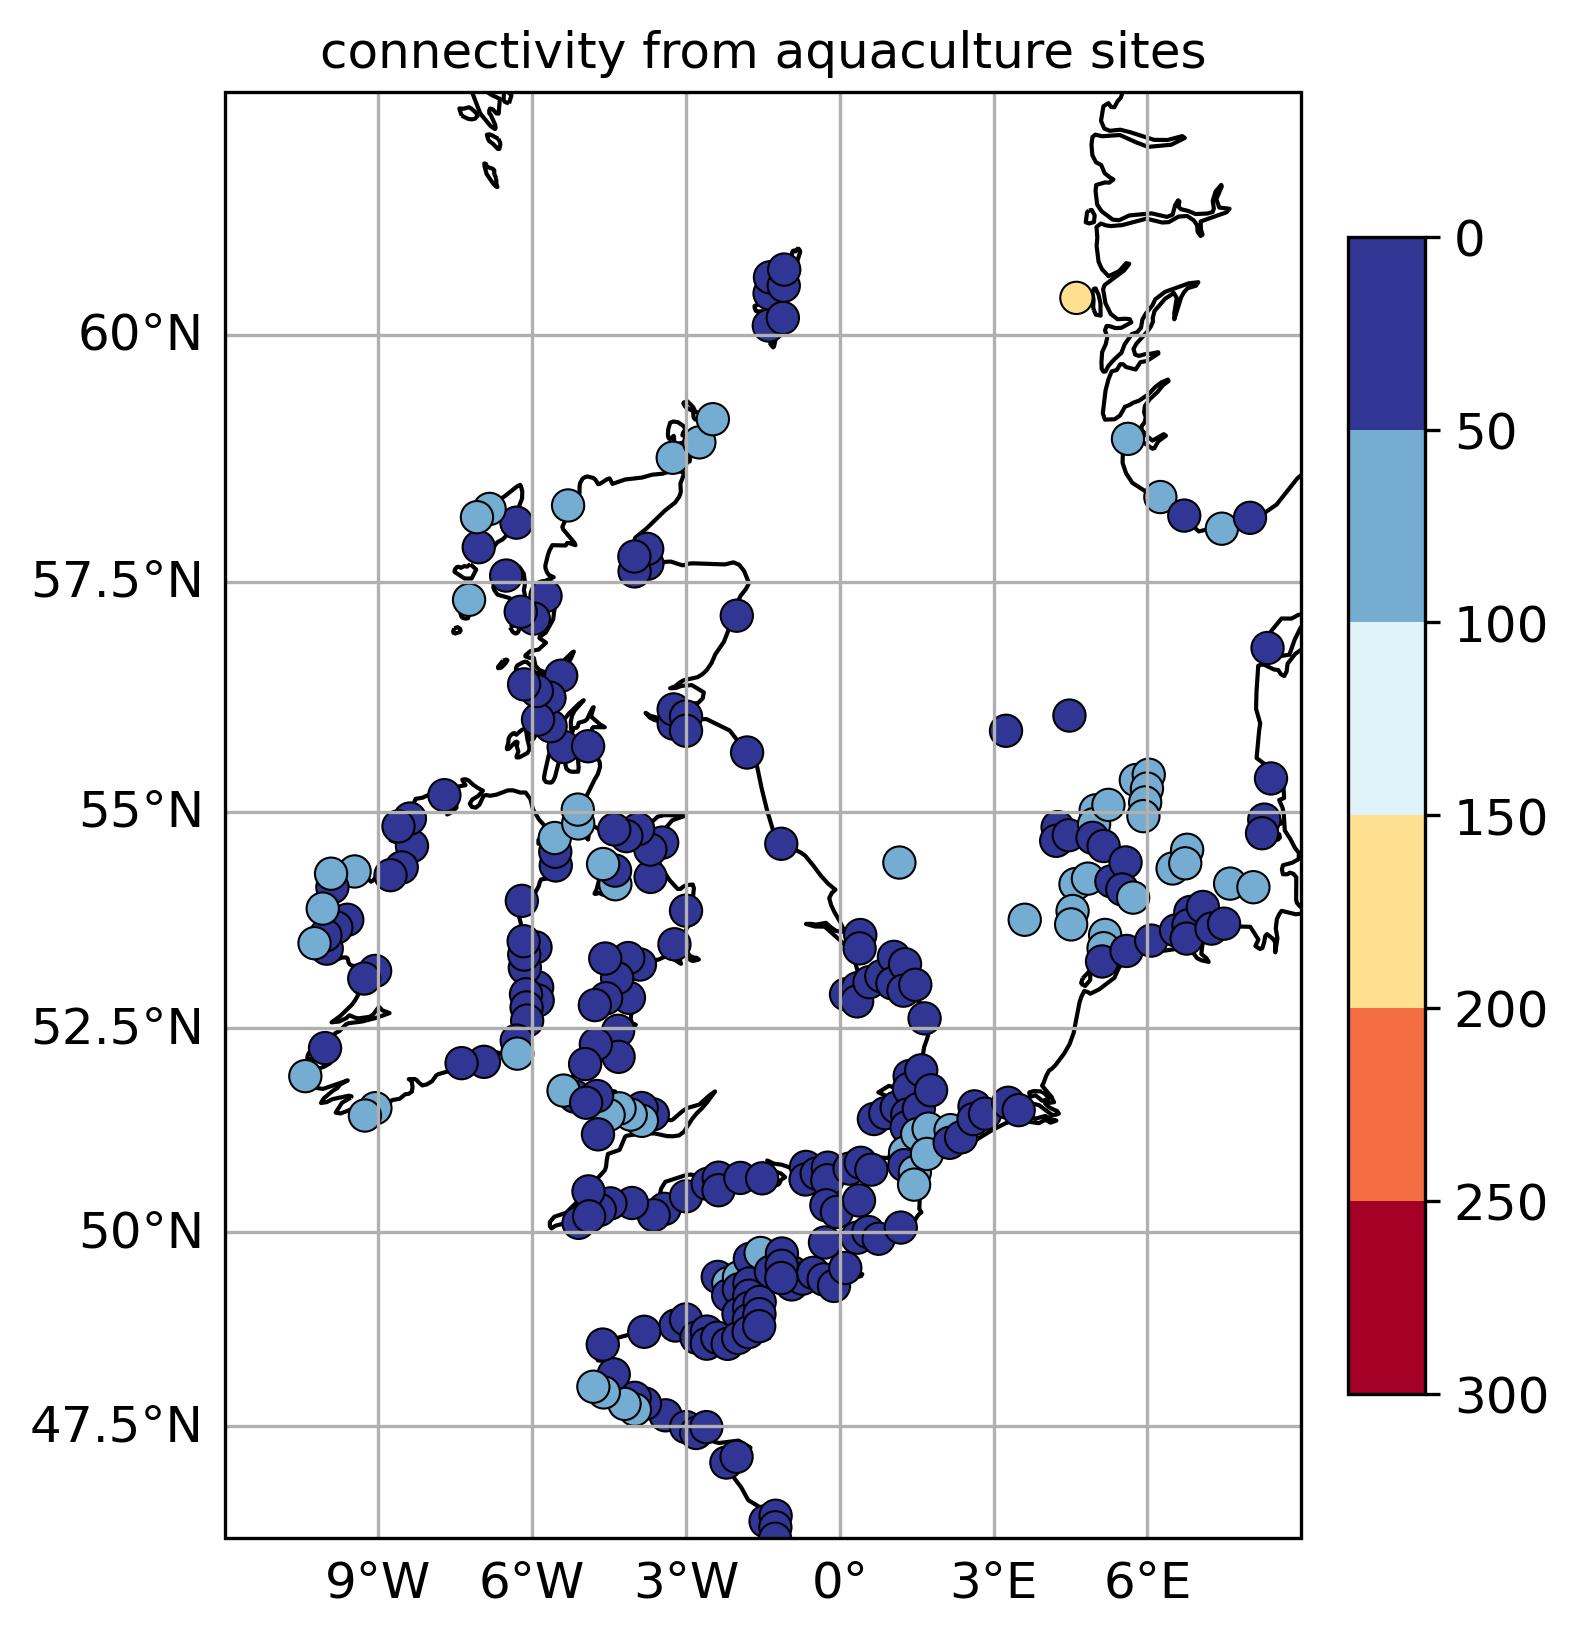

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_his_plot_df["lon_hex0"], known_his_plot_df["lat_hex0"],
    c=known_his_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_his_to_hab_05m_00-07.pdf")

### Historical to habitable AVERAGE 07-14

In [ ]:
his_to_habitable_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.his_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_14.depth_median_hex0 < 85)
    | (ds_conn_14.pop_count_hex0 > 0)
    | (ds_conn_14.his_count_hex0 > 0)
    | (ds_conn_14.rst_count_hex0 > 0)
    | (ds_conn_14.aqc_count_hex0 > 0)
    | (ds_conn_14.dss_count_hex0 > 0)
    | (ds_conn_14.hly_count_hex0 > 0)
)

In [64]:
known_his_sites = ds_conn_14.his_count_hex0.where(ds_conn_14.his_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [65]:
connected = (his_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [66]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_his_plot_df = known_his_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_his_plot_df = known_his_plot_df.dropna(subset=["num_connected_hab"])

In [67]:
known_his_plot_df.num_connected_hab.max()

208

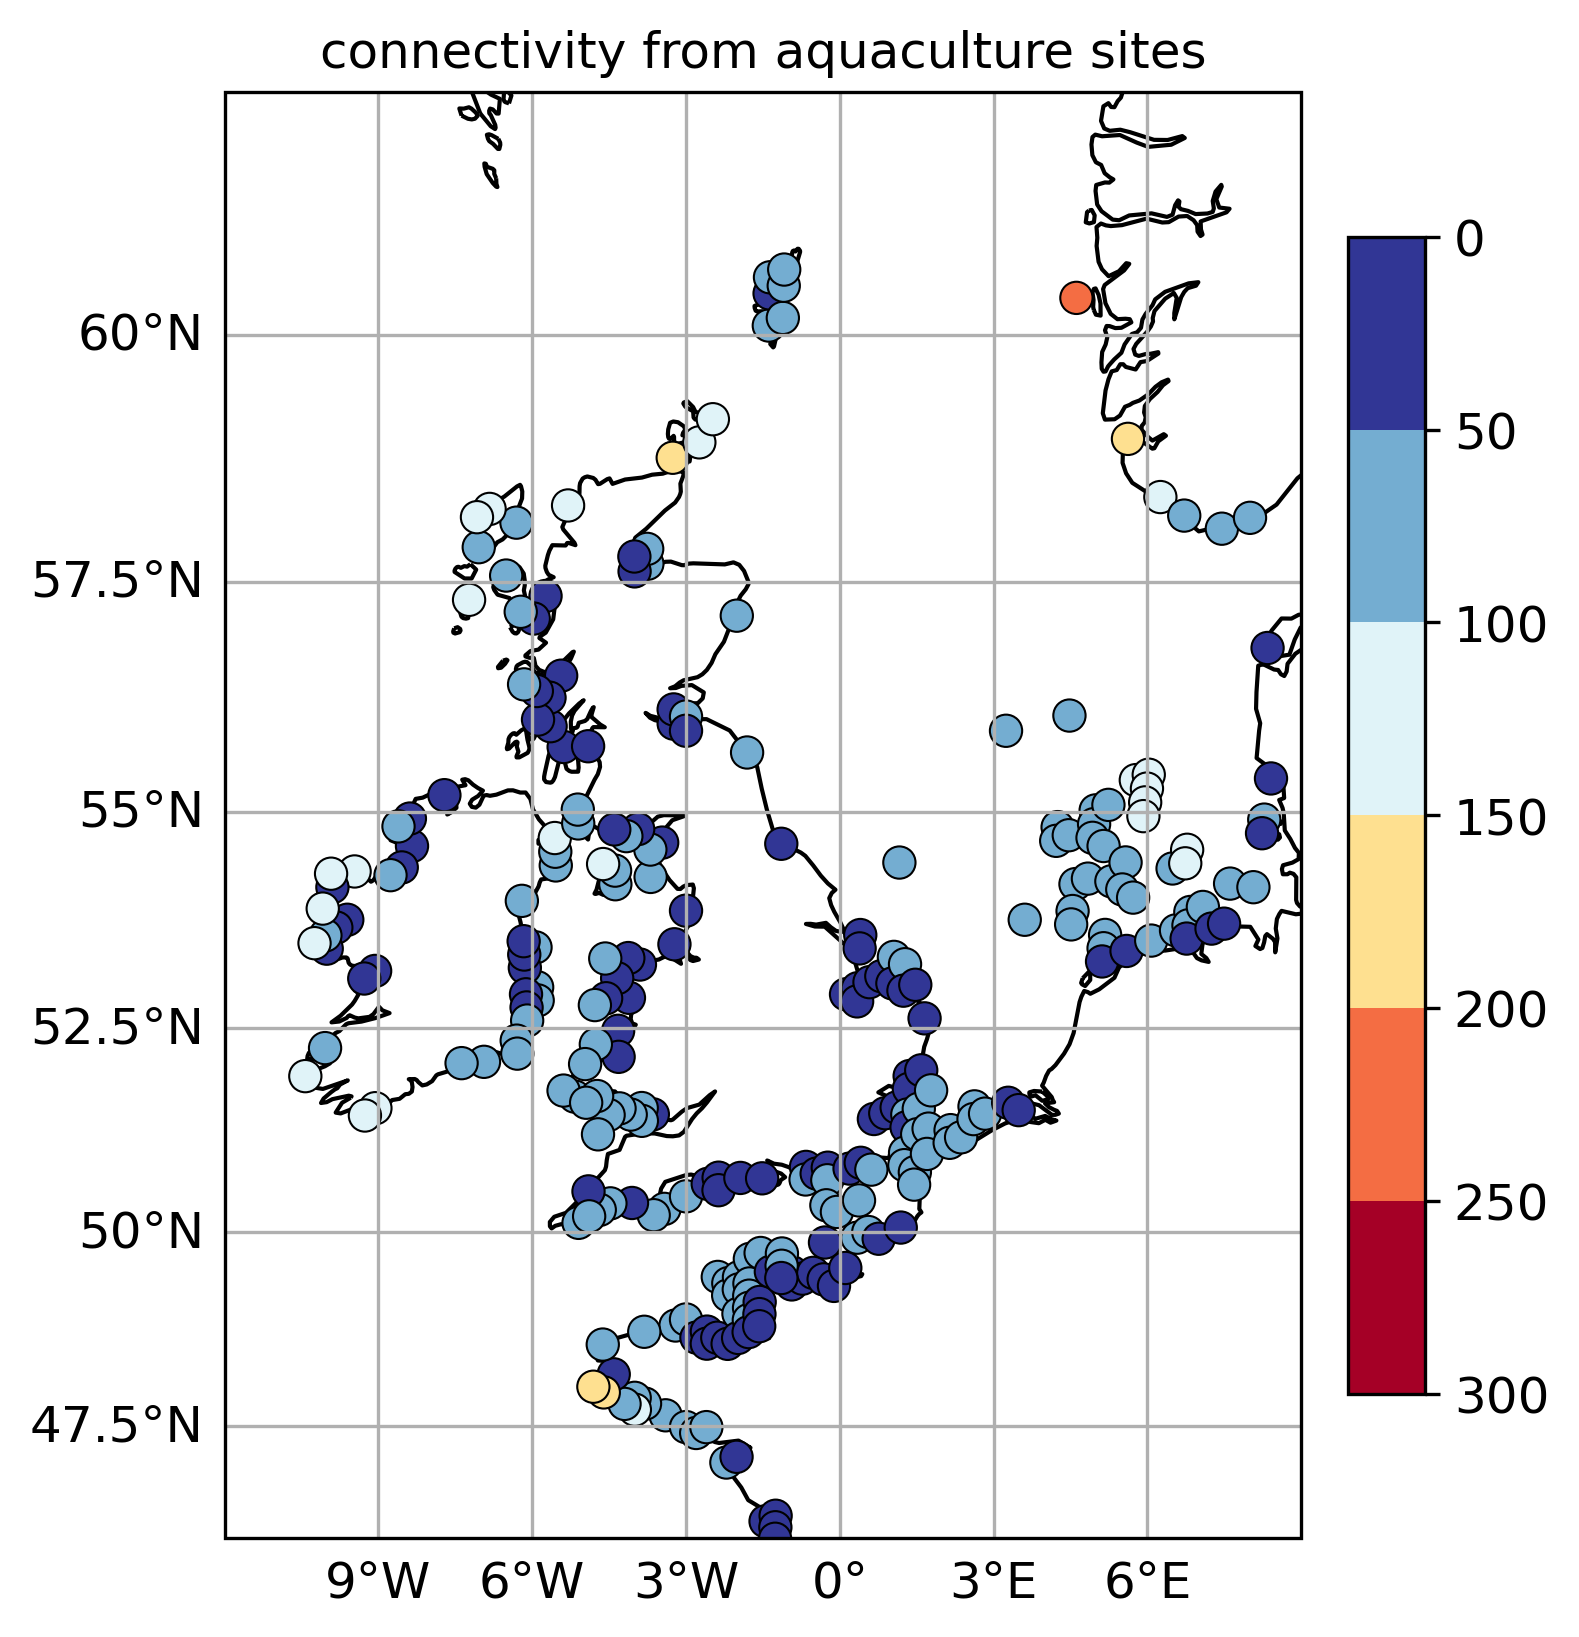

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_his_plot_df["lon_hex0"], known_his_plot_df["lat_hex0"],
    c=known_his_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_his_to_hab_05m_07-14.pdf")

### Historical to habitable AVERAGE 07-28

In [ ]:
his_to_habitable_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.his_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_28.depth_median_hex0 < 85)
    | (ds_conn_28.pop_count_hex0 > 0)
    | (ds_conn_28.his_count_hex0 > 0)
    | (ds_conn_28.rst_count_hex0 > 0)
    | (ds_conn_28.aqc_count_hex0 > 0)
    | (ds_conn_28.dss_count_hex0 > 0)
    | (ds_conn_28.hly_count_hex0 > 0)
)

In [70]:
known_his_sites = ds_conn_28.his_count_hex0.where(ds_conn_28.his_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [71]:
connected = (his_to_habitable_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [72]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_his_plot_df = known_his_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_his_plot_df = known_his_plot_df.dropna(subset=["num_connected_hab"])

In [73]:
known_his_plot_df.num_connected_hab.max()

313

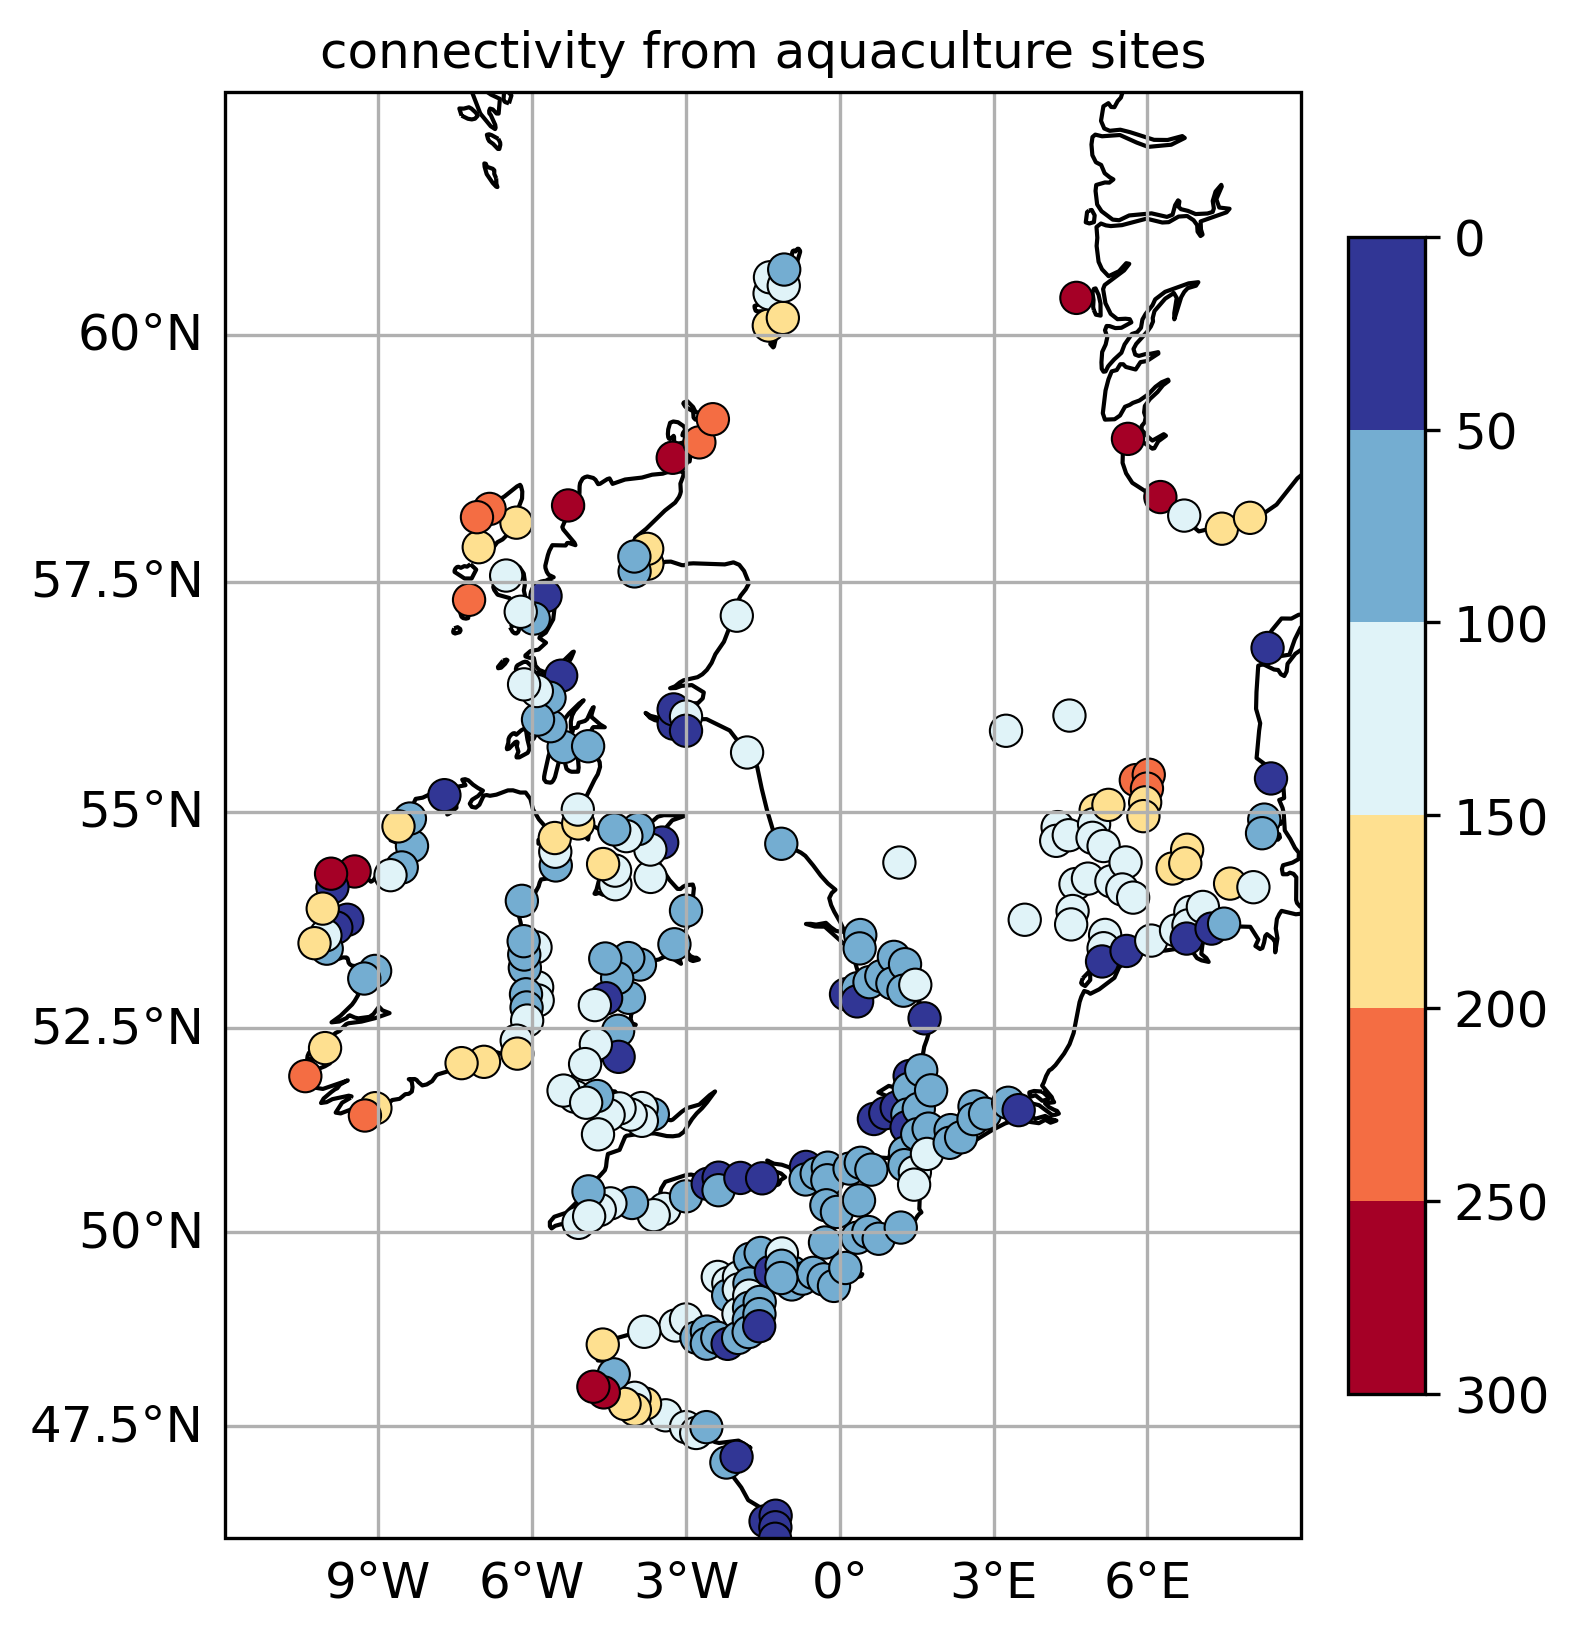

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 50, 100, 150, 200, 250, 300]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026'
 ]

#category_colors = [
#    '#ffffff', '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_his_plot_df["lon_hex0"], known_his_plot_df["lat_hex0"],
    c=known_his_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_his_to_hab_05m_07-28.pdf")

## Highly connected to restoration

### Diseased to restoration AVERAGE 00-07

In [107]:
dss_to_rst_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_07.rst_count_hex1 > 0)
)

In [108]:
known_dss_sites = ds_conn_07.dss_count_hex0.where(ds_conn_07.dss_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [109]:
known_rst_sites = ds_conn_07.rst_count_hex0.where(ds_conn_07.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [110]:
connected = (dss_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [111]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_rst") 
    .to_pandas()
)
known_dss_plot_df = known_dss_sites.join(
    hex0_connected_counts_clean[["num_connected_rst"]],
    how="inner"
)
known_dss_plot_df = known_dss_plot_df.dropna(subset=["num_connected_rst"])

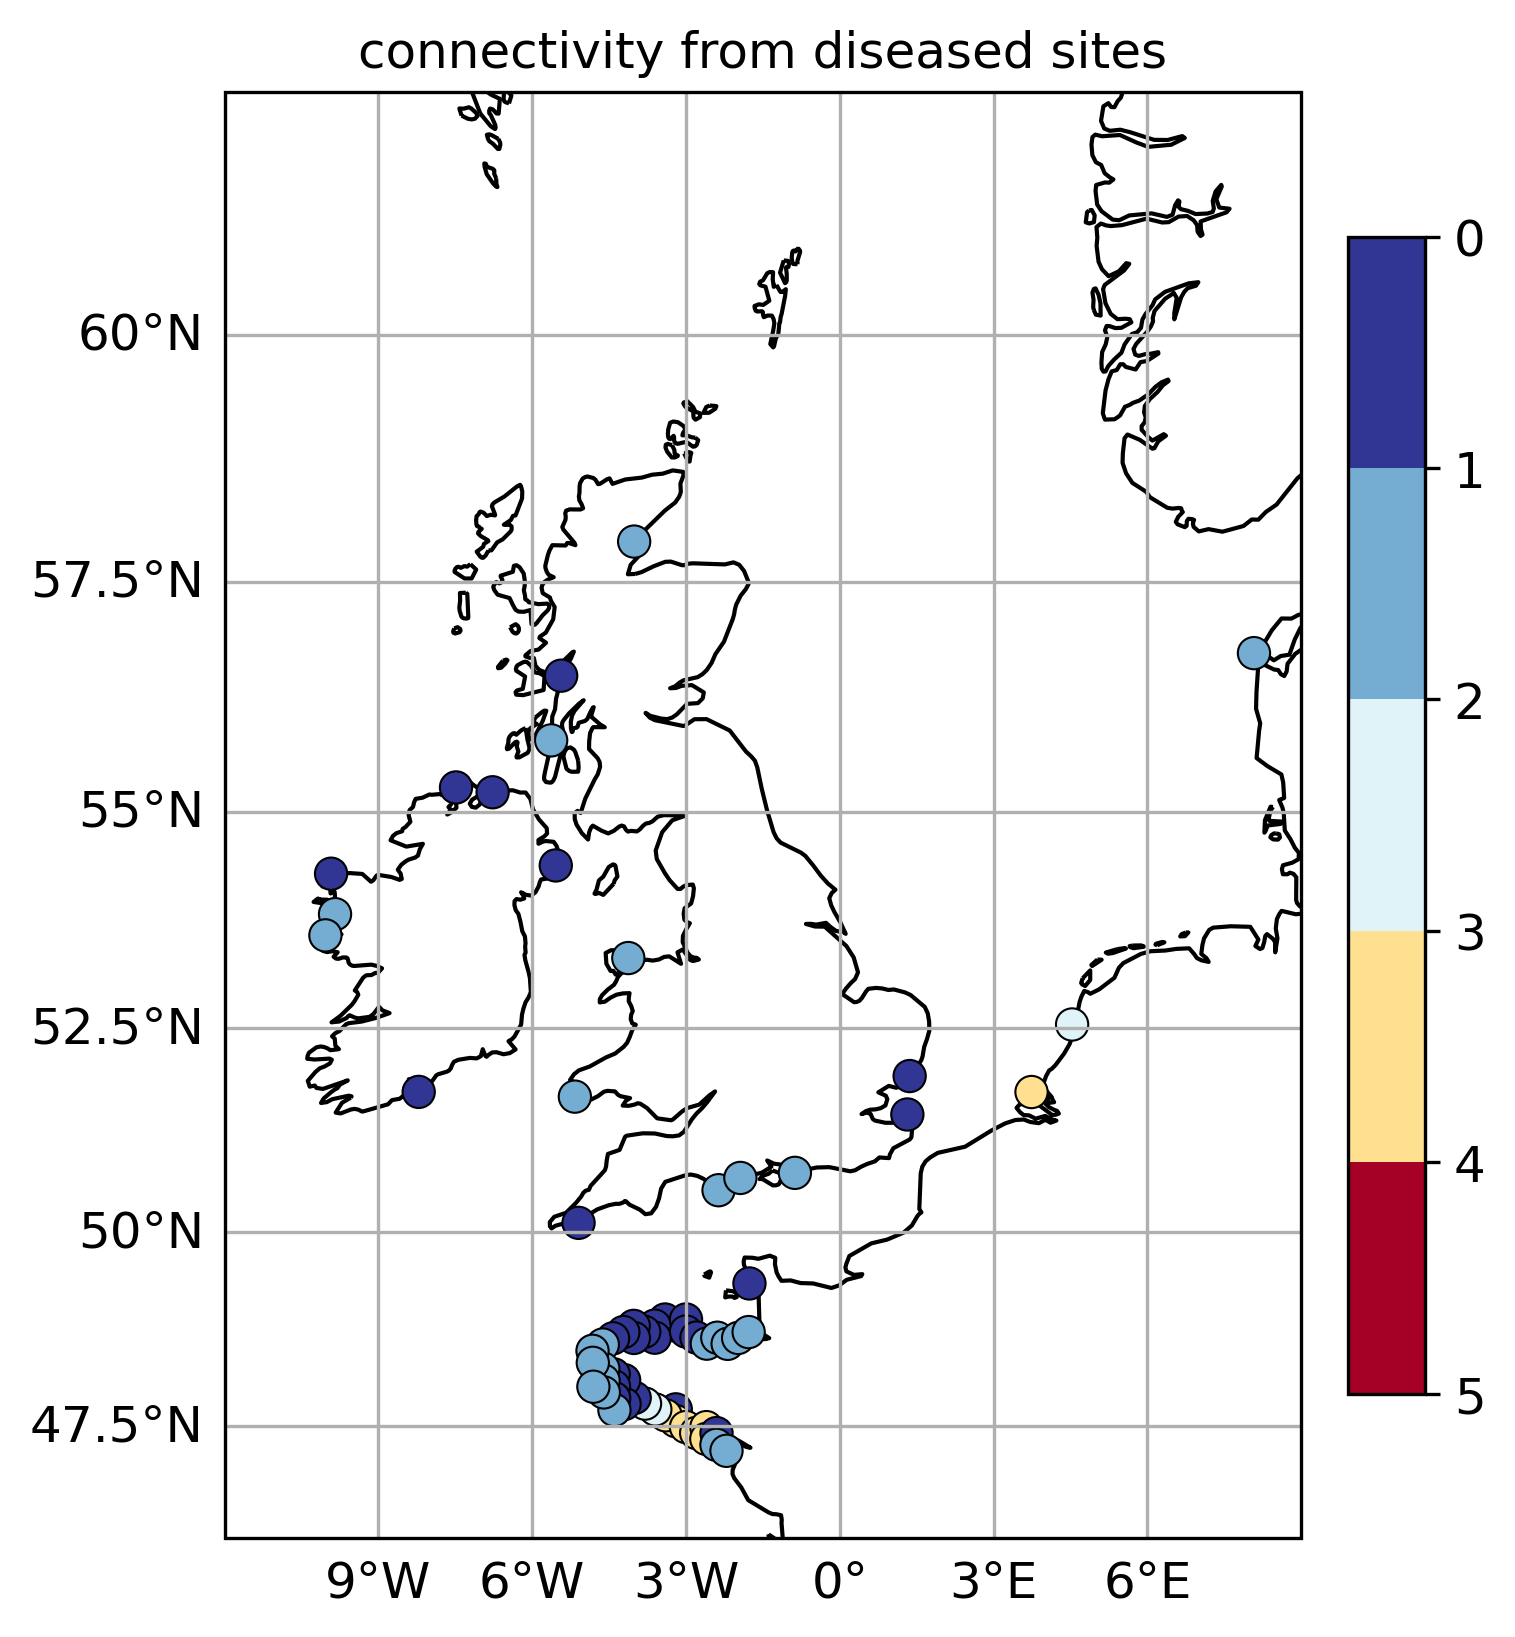

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]
#bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
#category_colors = [
#    '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]
cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_dss_plot_df["lon_hex0"], known_dss_plot_df["lat_hex0"],
    c=known_dss_plot_df["num_connected_rst"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from diseased sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_dss_to_rst_05m_00-07.pdf")

### Diseased to restoration AVERAGE 07-14

In [101]:
dss_to_rst_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_14.rst_count_hex1 > 0)
)

In [102]:
known_dss_sites = ds_conn_14.dss_count_hex0.where(ds_conn_14.dss_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [103]:
known_rst_sites = ds_conn_14.rst_count_hex0.where(ds_conn_14.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [104]:
connected = (dss_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [105]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_rst") 
    .to_pandas()
)
known_dss_plot_df = known_dss_sites.join(
    hex0_connected_counts_clean[["num_connected_rst"]],
    how="inner"
)
known_dss_plot_df = known_dss_plot_df.dropna(subset=["num_connected_rst"])

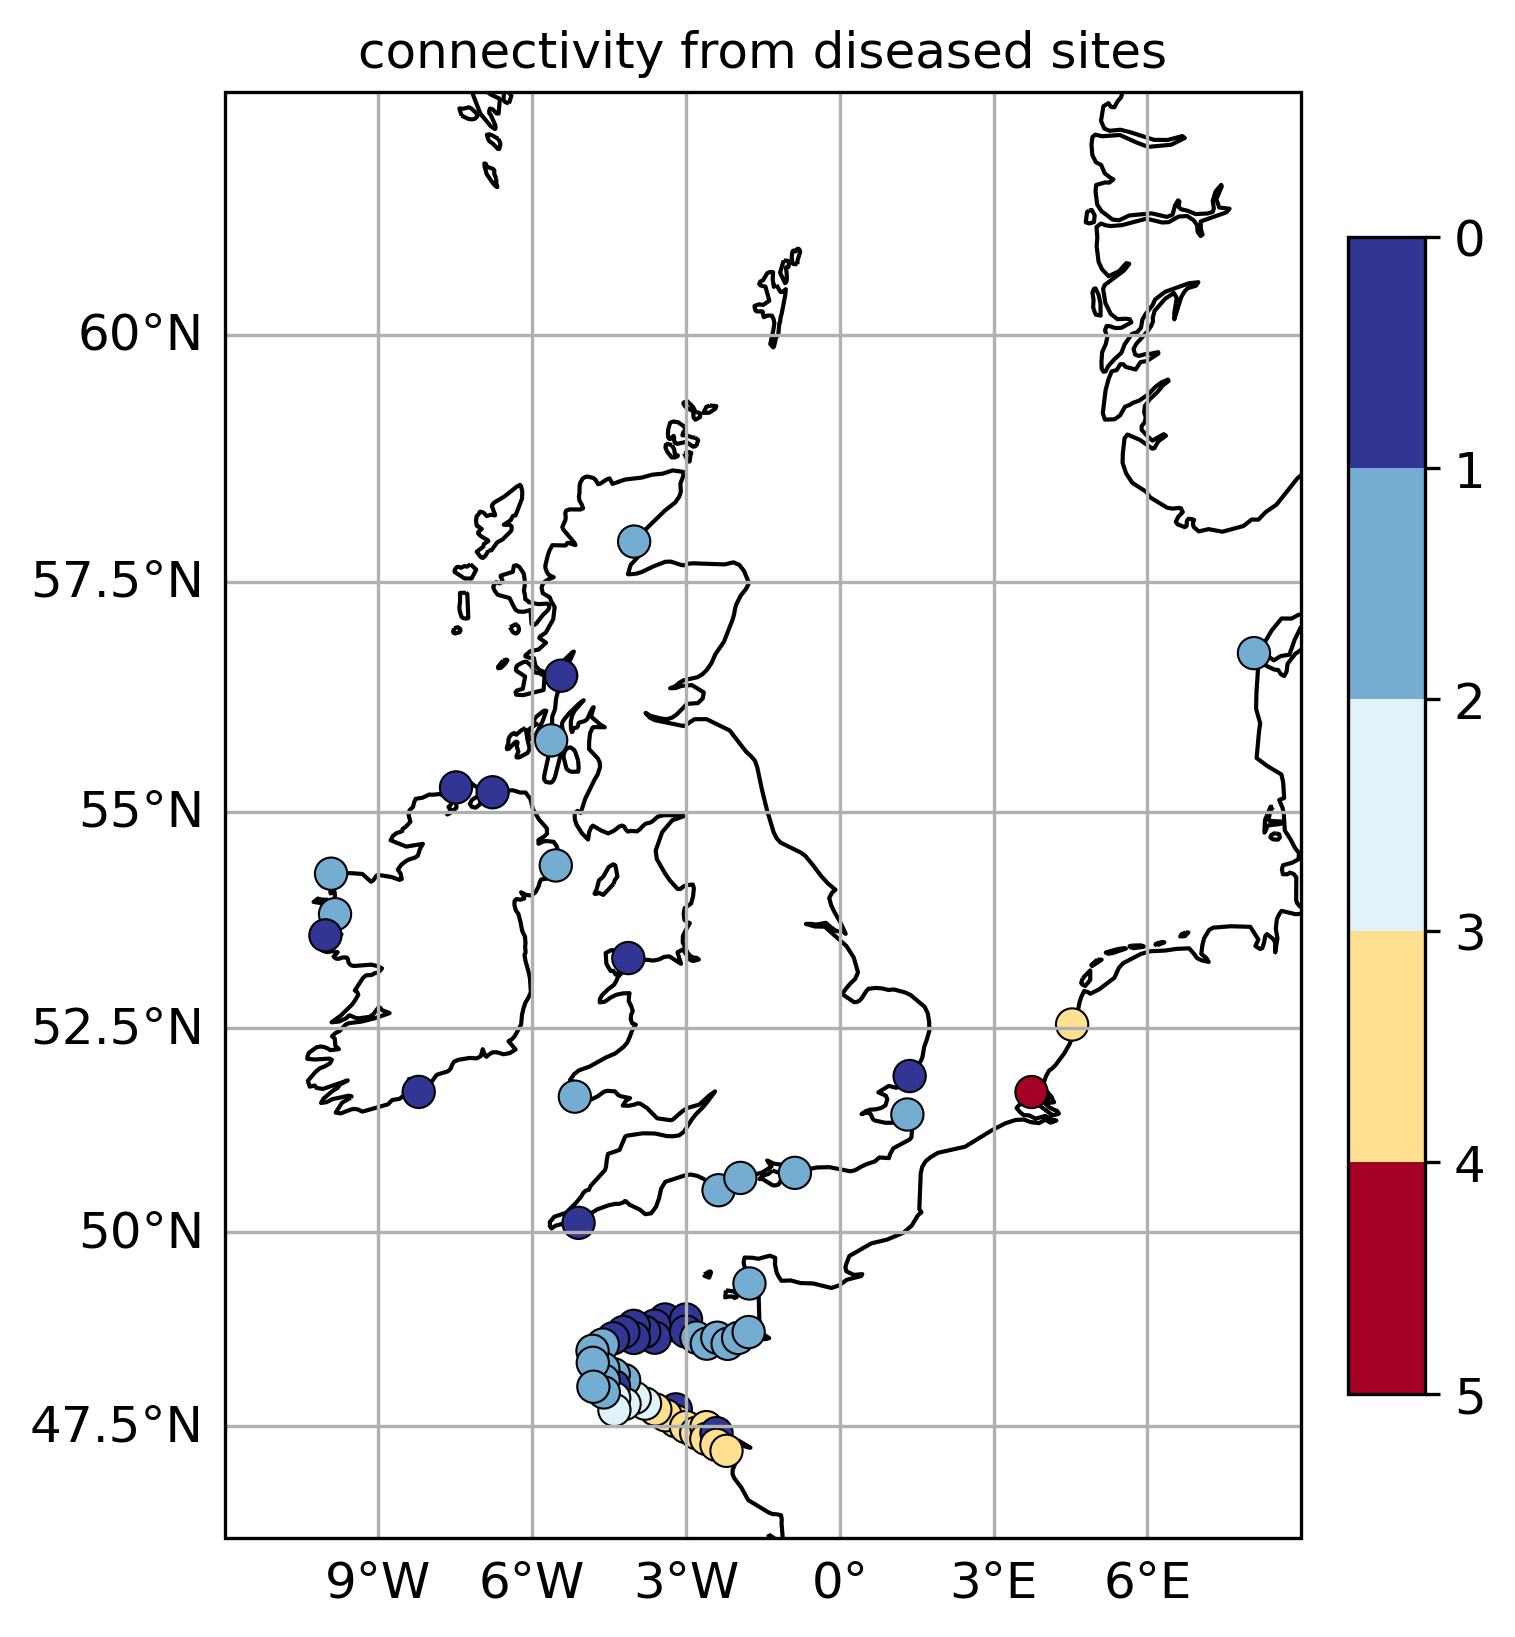

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]
#bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
#category_colors = [
#    '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]
cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_dss_plot_df["lon_hex0"], known_dss_plot_df["lat_hex0"],
    c=known_dss_plot_df["num_connected_rst"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from diseased sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_dss_to_rst_05m_07-14.pdf")

### Diseased to restoration AVERAGE 07-28

In [113]:
dss_to_rst_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_28.rst_count_hex1 > 0)
)

In [114]:
known_dss_sites = ds_conn_28.dss_count_hex0.where(ds_conn_28.dss_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [115]:
known_rst_sites = ds_conn_28.rst_count_hex0.where(ds_conn_28.rst_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [116]:
connected = (dss_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [117]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_rst") 
    .to_pandas()
)
known_dss_plot_df = known_dss_sites.join(
    hex0_connected_counts_clean[["num_connected_rst"]],
    how="inner"
)
known_dss_plot_df = known_dss_plot_df.dropna(subset=["num_connected_rst"])

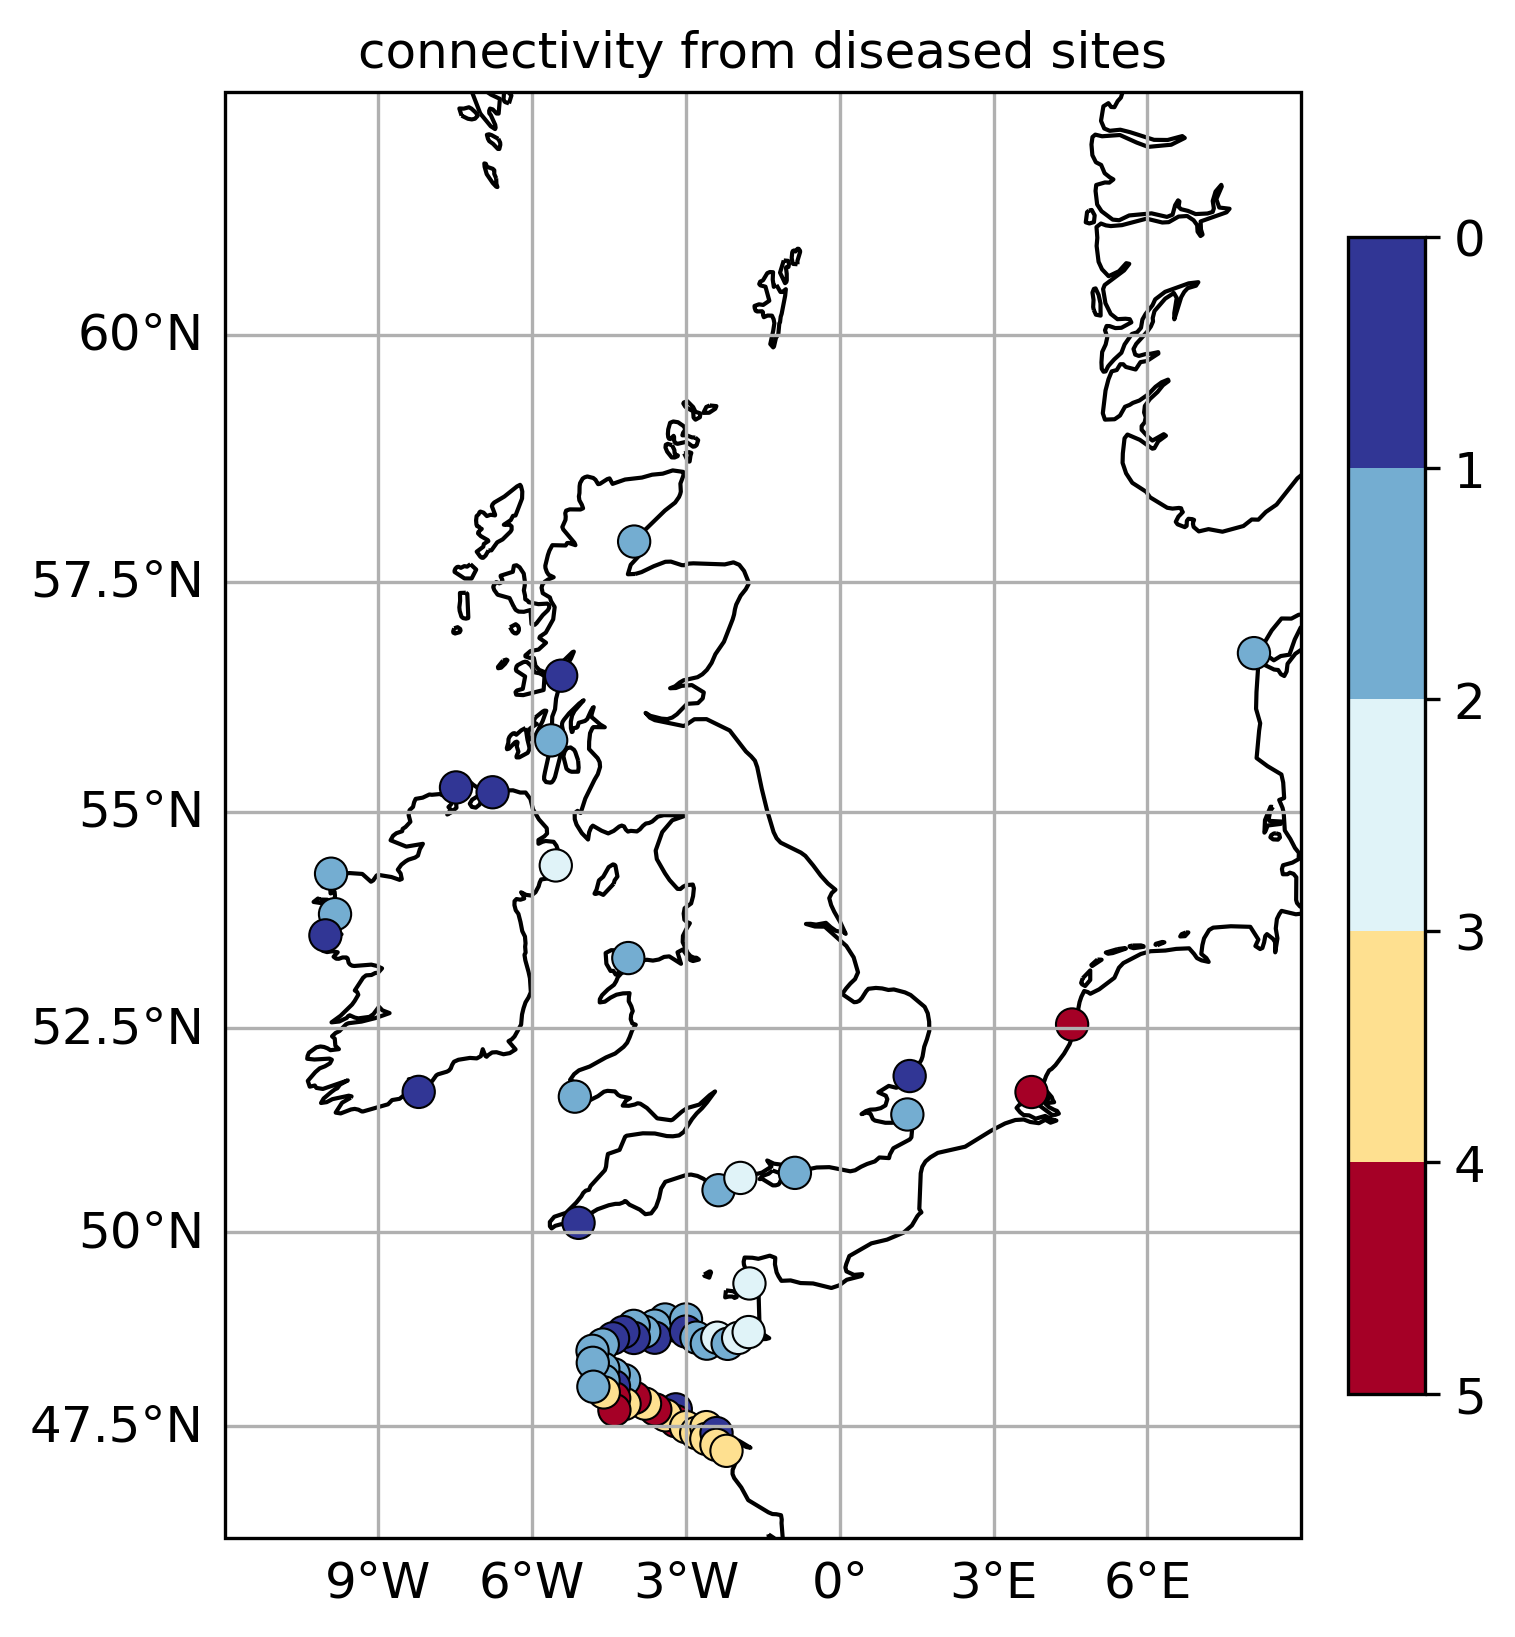

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]
#bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
#category_colors = [
#    '#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#d9d9d9','#fee090','#fdae61','#f46d43', '#d73027','#a50026',
#]
cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_dss_plot_df["lon_hex0"], known_dss_plot_df["lat_hex0"],
    c=known_dss_plot_df["num_connected_rst"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from diseased sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_dss_to_rst_05m_00-07.pdf")

## Highly connected aquaculture to restoration

### Aquaculture to restoration AVERAGE 00-07

In [121]:
aq_to_rst_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_07.rst_count_hex1 > 0)
)

In [122]:
known_aq_sites = ds_conn_07.aqc_count_hex0.where(ds_conn_07.aqc_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [123]:
connected = (aq_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [124]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_aq_plot_df = known_aq_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_aq_plot_df = known_aq_plot_df.dropna(subset=["num_connected_hab"])

In [129]:
known_aq_plot_df.num_connected_hab.max()

3

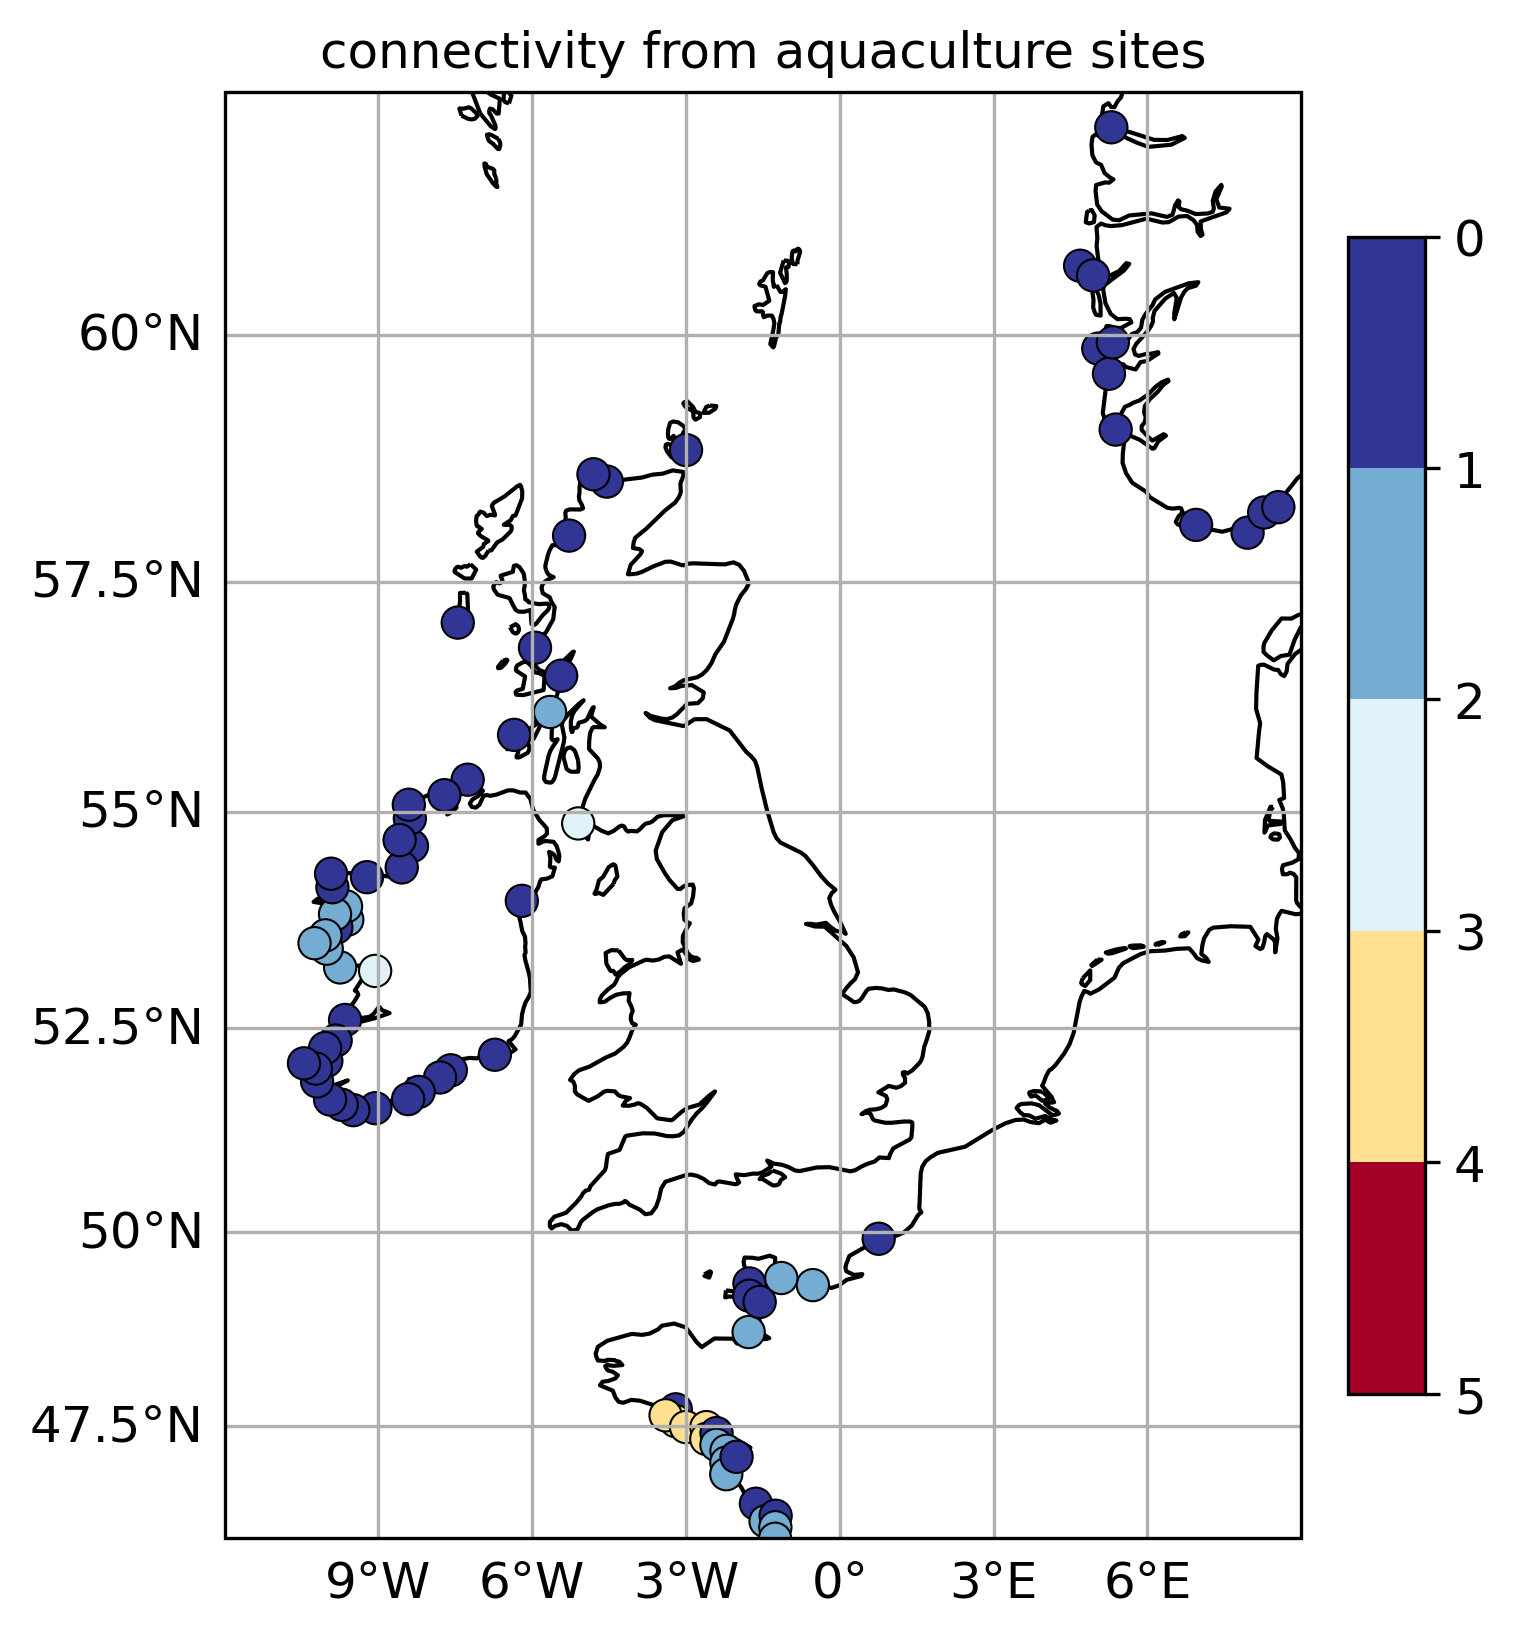

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_aq_plot_df["lon_hex0"], known_aq_plot_df["lat_hex0"],
    c=known_aq_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_aq_to_hab_05m_00-07.pdf")

### Aquaculture to restoration AVERAGE 07-14

In [130]:
aq_to_rst_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_14.rst_count_hex1 > 0)
)

In [131]:
known_aq_sites = ds_conn_14.aqc_count_hex0.where(ds_conn_14.aqc_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [132]:
connected = (aq_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [133]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_aq_plot_df = known_aq_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_aq_plot_df = known_aq_plot_df.dropna(subset=["num_connected_hab"])

In [134]:
known_aq_plot_df.num_connected_hab.max()

3

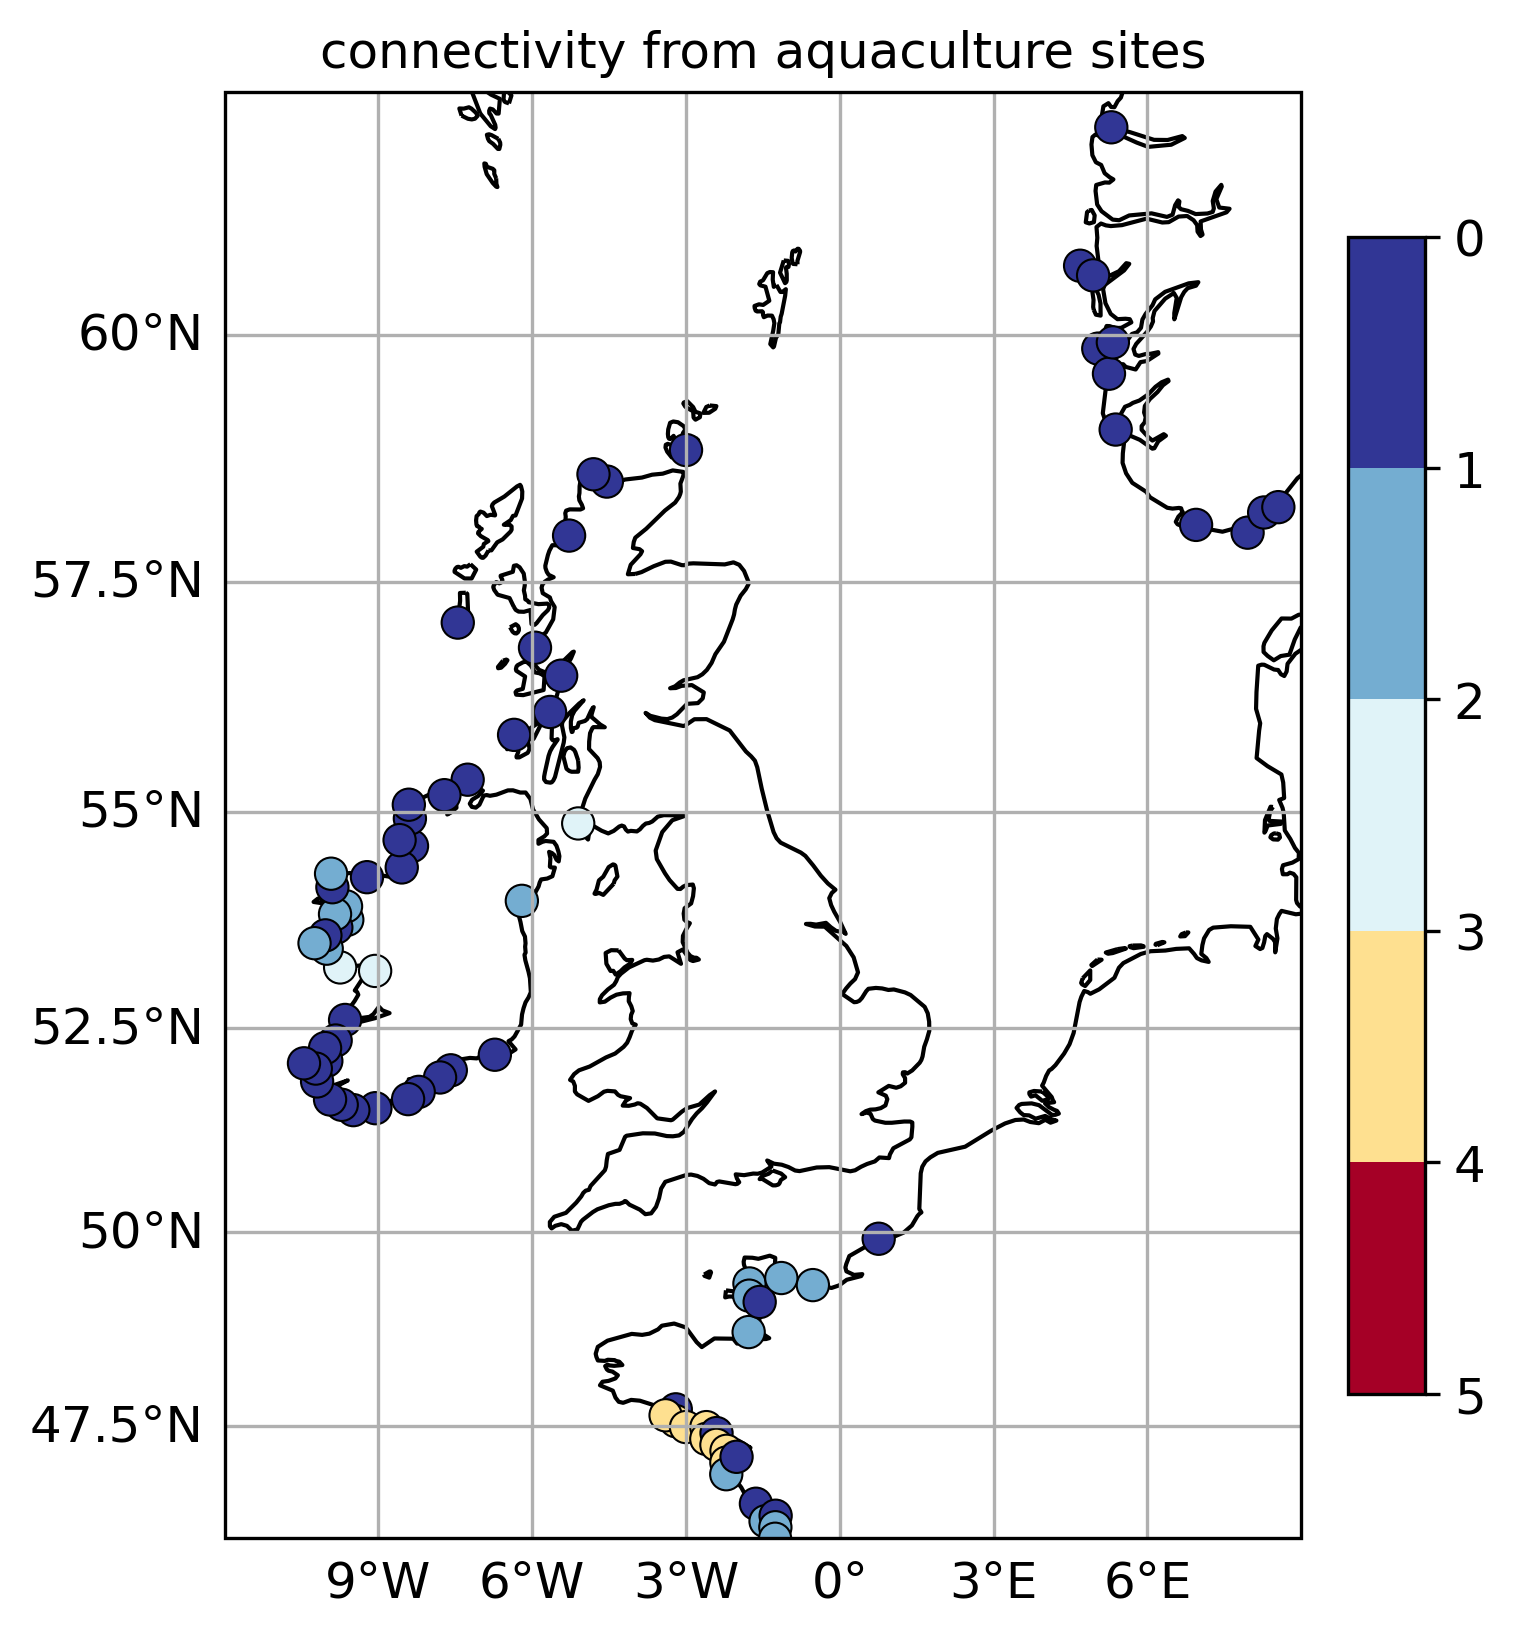

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_aq_plot_df["lon_hex0"], known_aq_plot_df["lat_hex0"],
    c=known_aq_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_aq_to_hab_05m_00-07.pdf")

### Aquaculture to restoration AVERAGE 07-28

In [136]:
aq_to_rst_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.aqc_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_28.rst_count_hex1 > 0)
)

In [137]:
known_aq_sites = ds_conn_28.aqc_count_hex0.where(ds_conn_28.aqc_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [138]:
connected = (aq_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [139]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_aq_plot_df = known_aq_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_aq_plot_df = known_aq_plot_df.dropna(subset=["num_connected_hab"])

In [140]:
known_aq_plot_df.num_connected_hab.max()

4

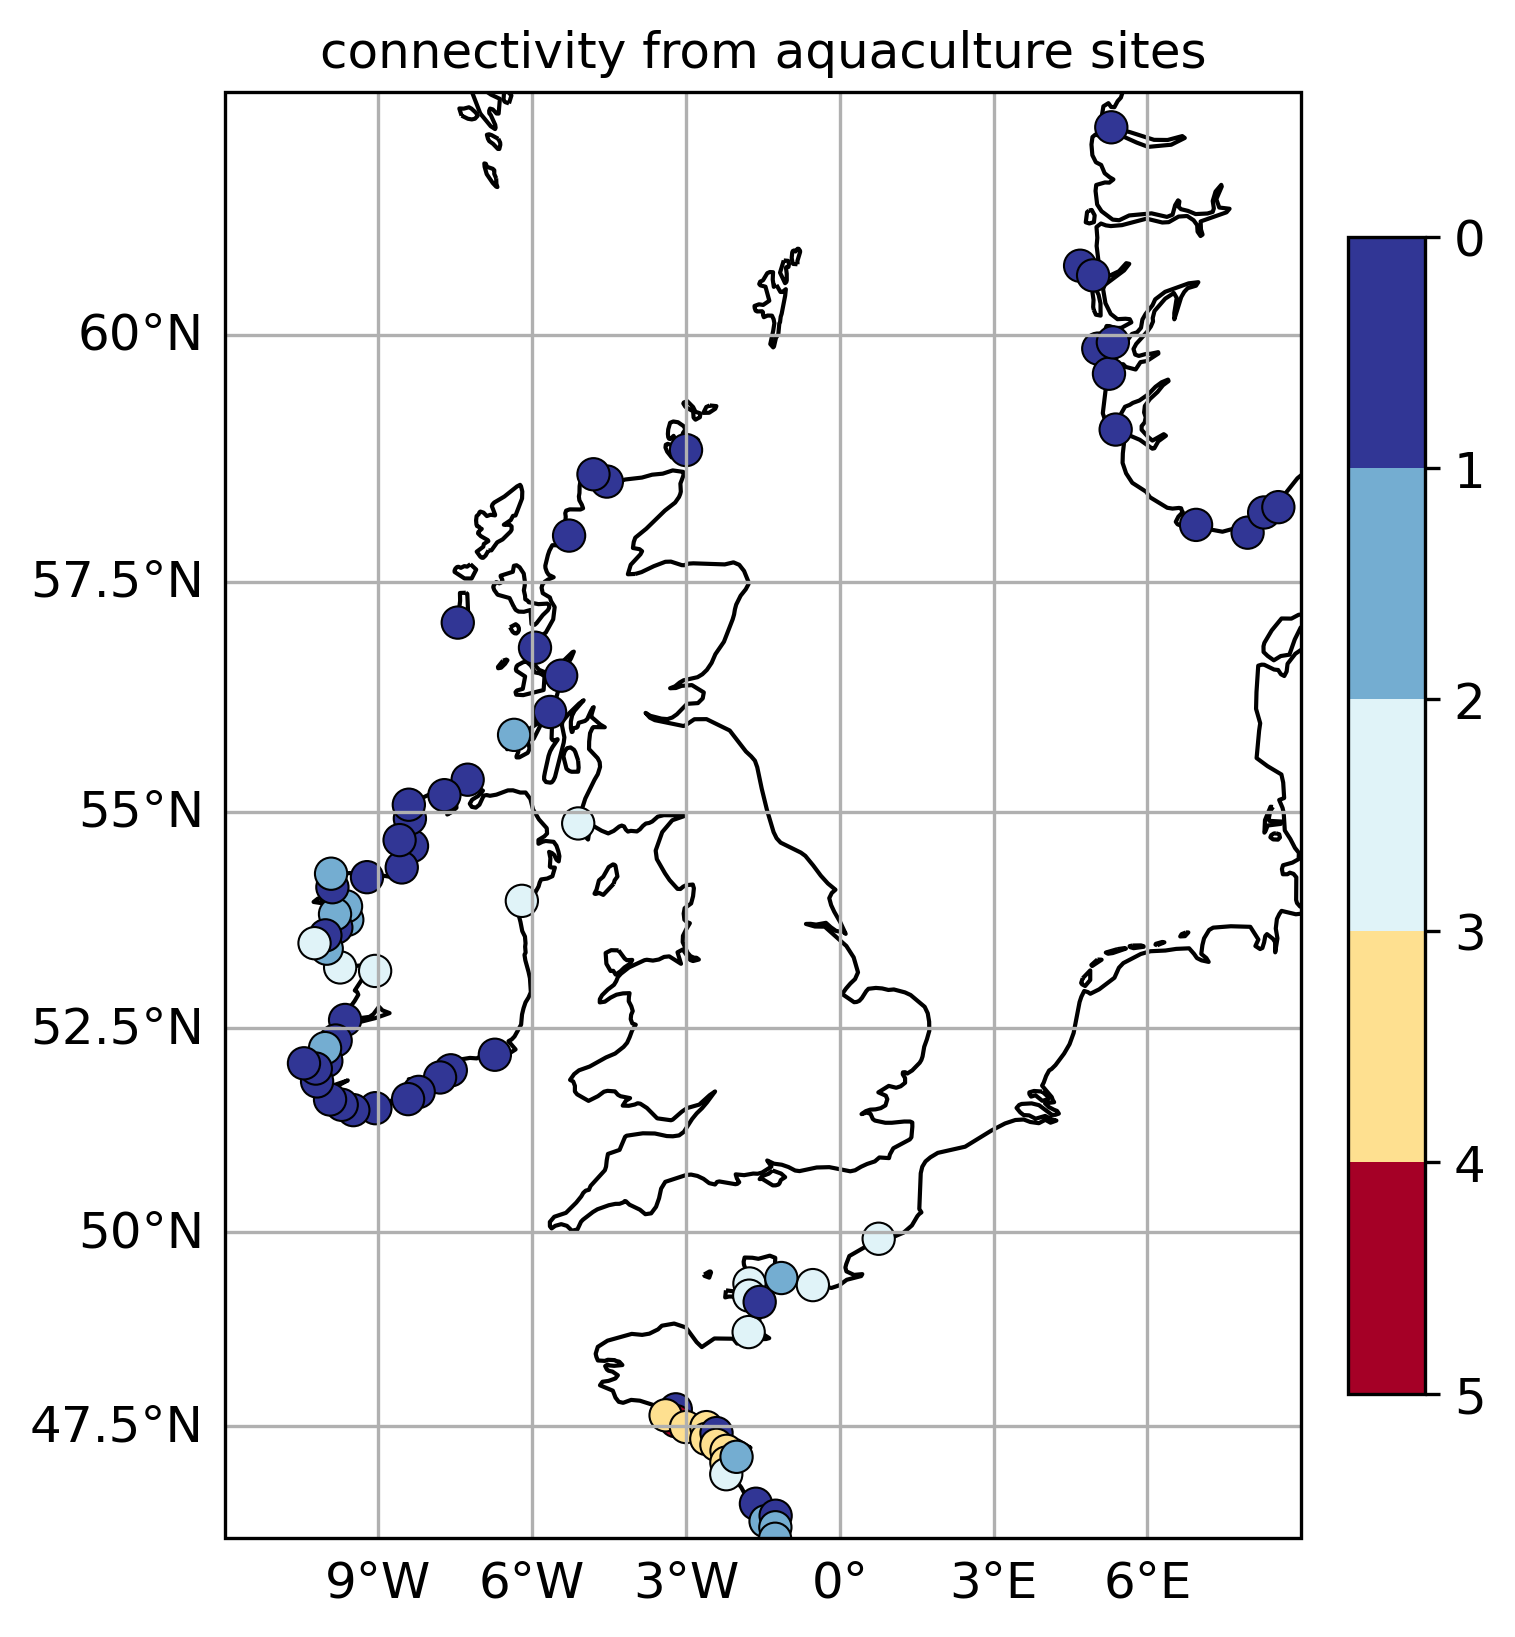

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_aq_plot_df["lon_hex0"], known_aq_plot_df["lat_hex0"],
    c=known_aq_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
#ax.set_title("connectivity from aquaculture sites")
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_aq_to_hab_05m_00-07.pdf")

## Highly connected historical to restoration 

### Historical to restoration AVERAGE 00-07

In [17]:
his_to_rst_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.his_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_07.rst_count_hex1 > 0)
)

In [18]:
known_his_sites = ds_conn_07.his_count_hex0.where(ds_conn_07.his_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [19]:
connected = (his_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [20]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_his_plot_df = known_his_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_his_plot_df = known_his_plot_df.dropna(subset=["num_connected_hab"])

In [21]:
known_his_plot_df.num_connected_hab.max()

4

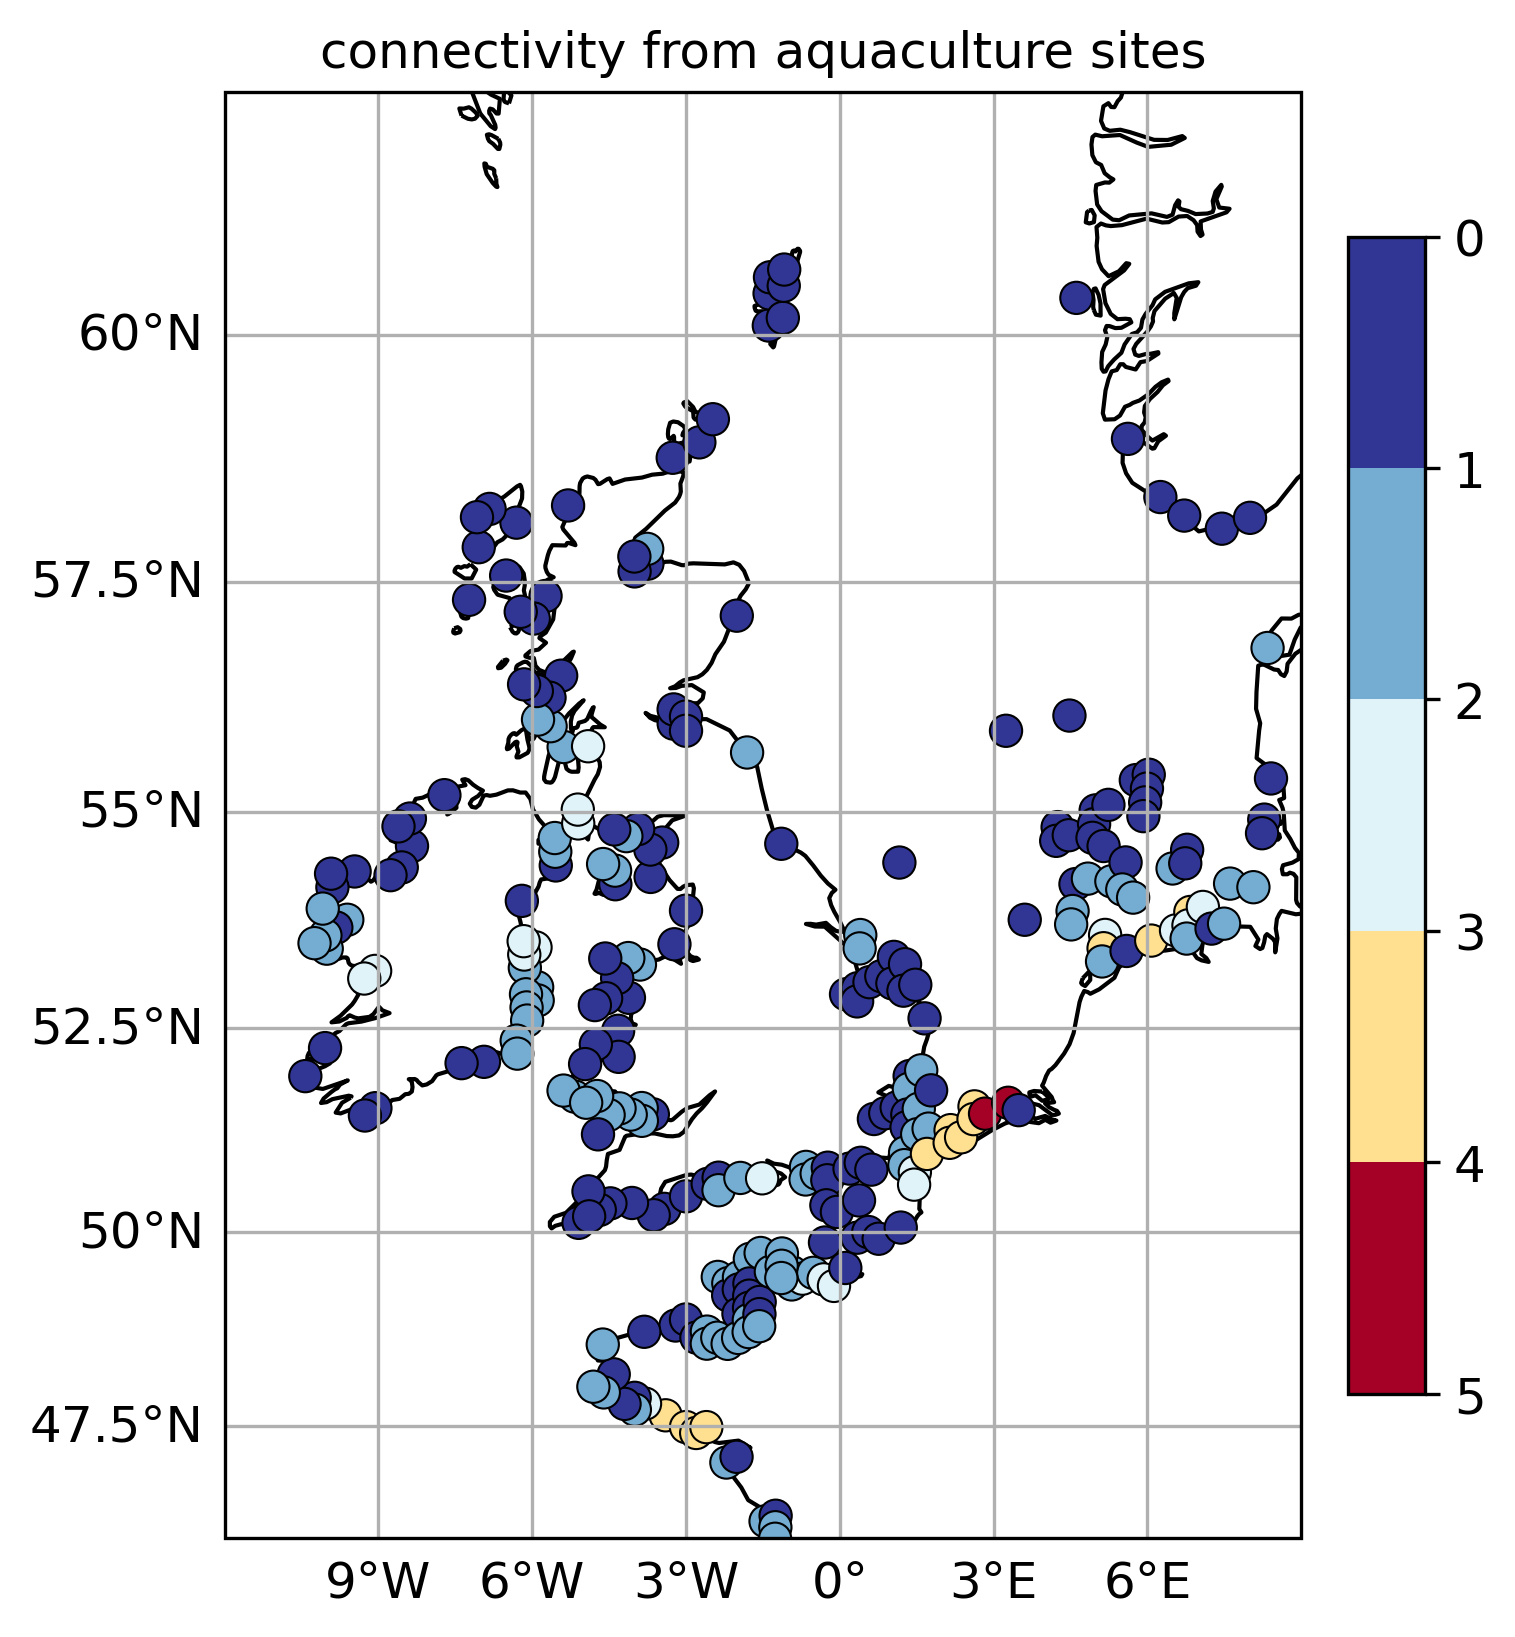

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_his_plot_df["lon_hex0"], known_his_plot_df["lat_hex0"],
    c=known_his_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_his_to_hab_05m_00-07.pdf")

### Historical to restoration AVERAGE 07-14

In [23]:
his_to_rst_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.his_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_14.rst_count_hex1 > 0)
)

In [24]:
known_his_sites = ds_conn_14.his_count_hex0.where(ds_conn_14.his_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [25]:
connected = (his_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [26]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_his_plot_df = known_his_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_his_plot_df = known_his_plot_df.dropna(subset=["num_connected_hab"])

In [27]:
known_his_plot_df.num_connected_hab.max()

5

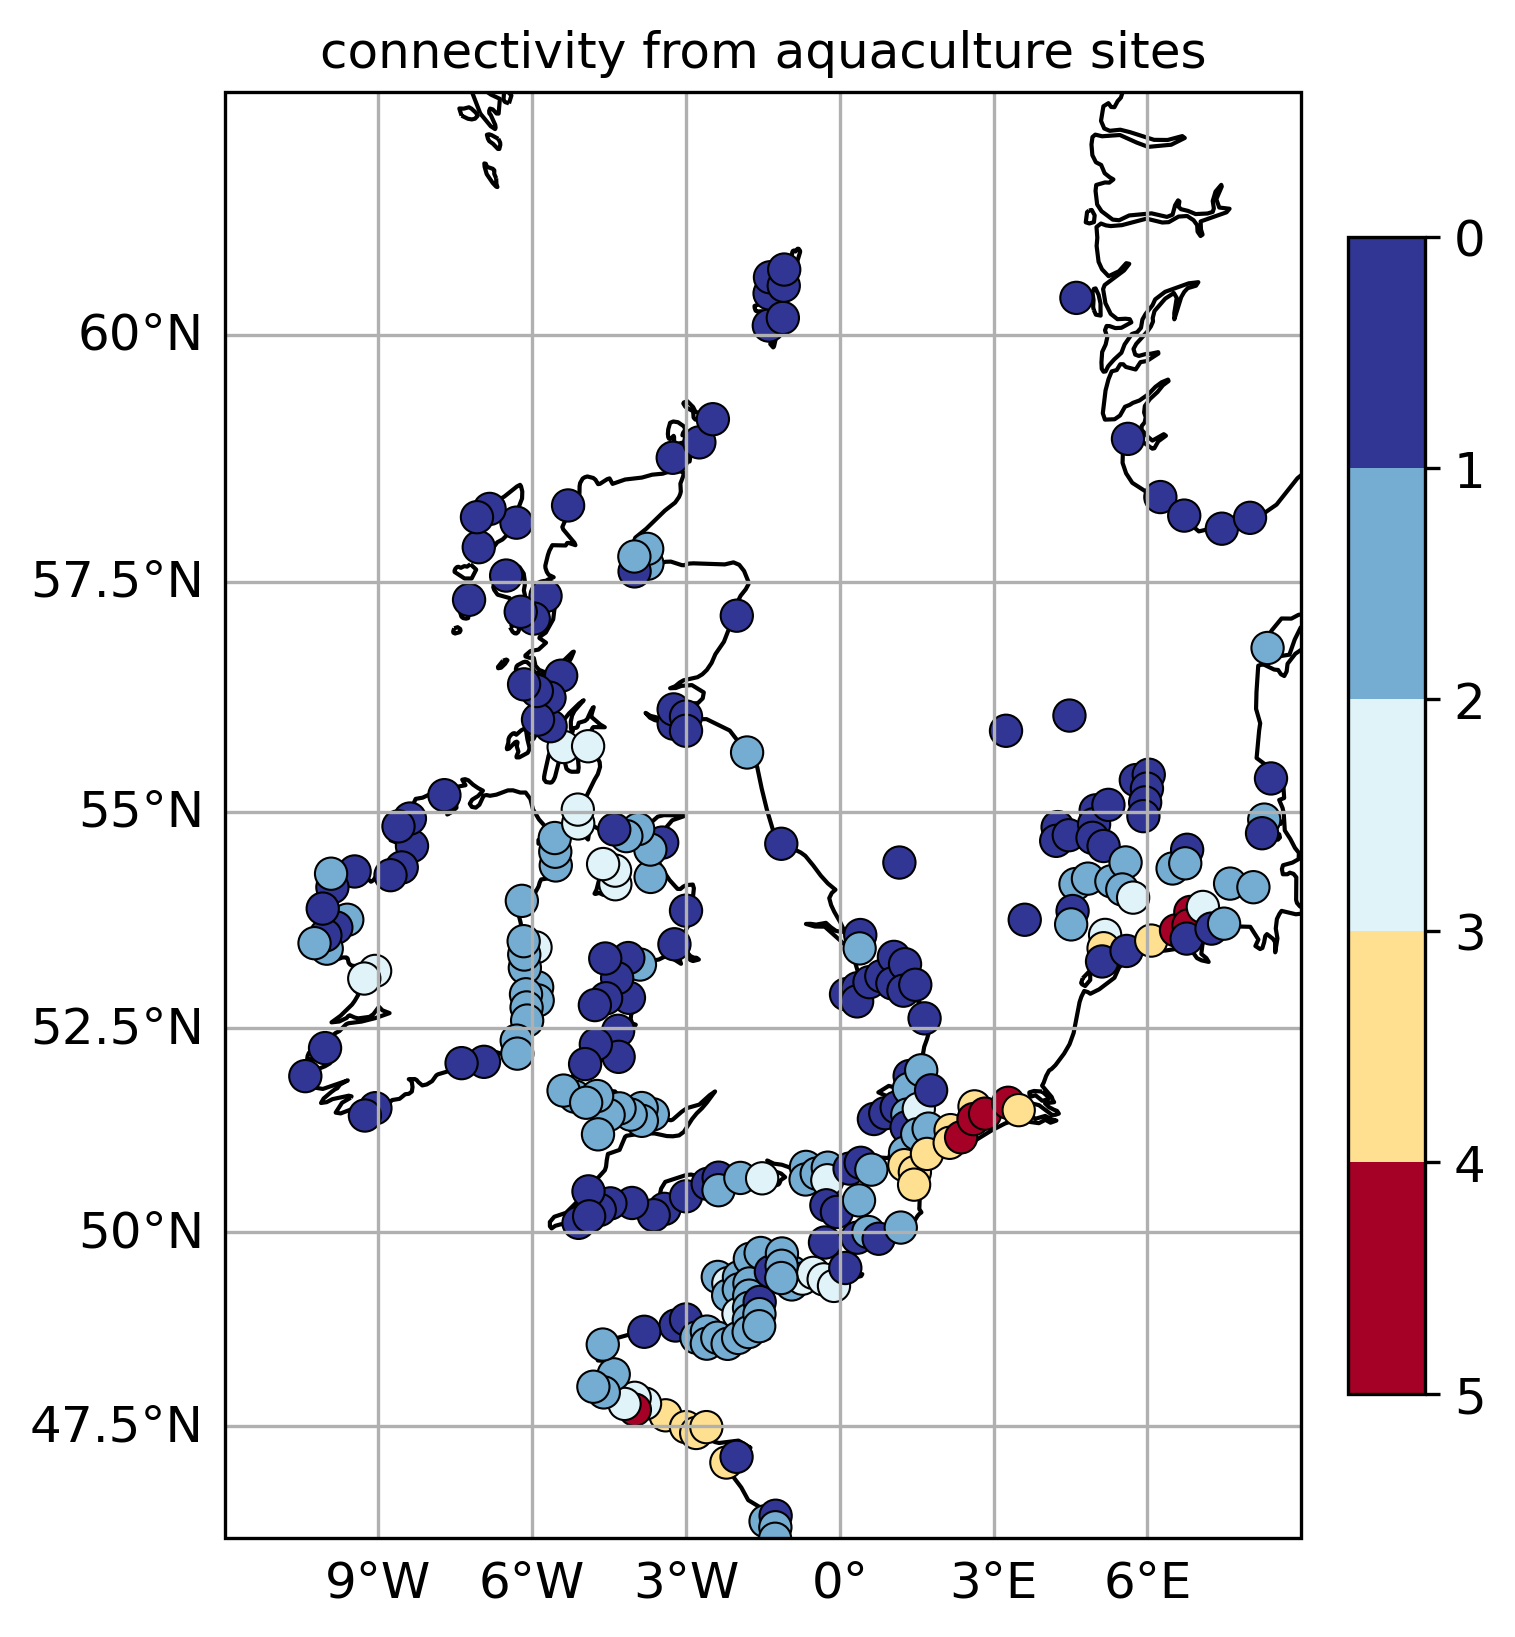

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_his_plot_df["lon_hex0"], known_his_plot_df["lat_hex0"],
    c=known_his_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_his_to_hab_05m_00-07.pdf")

### Historical to restoration AVERAGE 07-28

In [29]:
his_to_rst_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.his_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn_28.rst_count_hex1 > 0)
)

In [30]:
known_his_sites = ds_conn_28.his_count_hex0.where(ds_conn_28.his_count_hex0 > 0).to_dataset().to_pandas().dropna()

In [31]:
connected = (his_to_rst_01y > 0).any(dim=["month", "year"])
hex0_connected_counts = connected.sum(dim="hex1")

In [32]:
hex0_connected_counts_clean = (
    hex0_connected_counts
    .to_dataset(name="num_connected_hab") 
    .to_pandas()
)
known_his_plot_df = known_his_sites.join(
    hex0_connected_counts_clean[["num_connected_hab"]],
    how="inner"
)
known_his_plot_df = known_his_plot_df.dropna(subset=["num_connected_hab"])

In [33]:
known_his_plot_df.num_connected_hab.max()

5

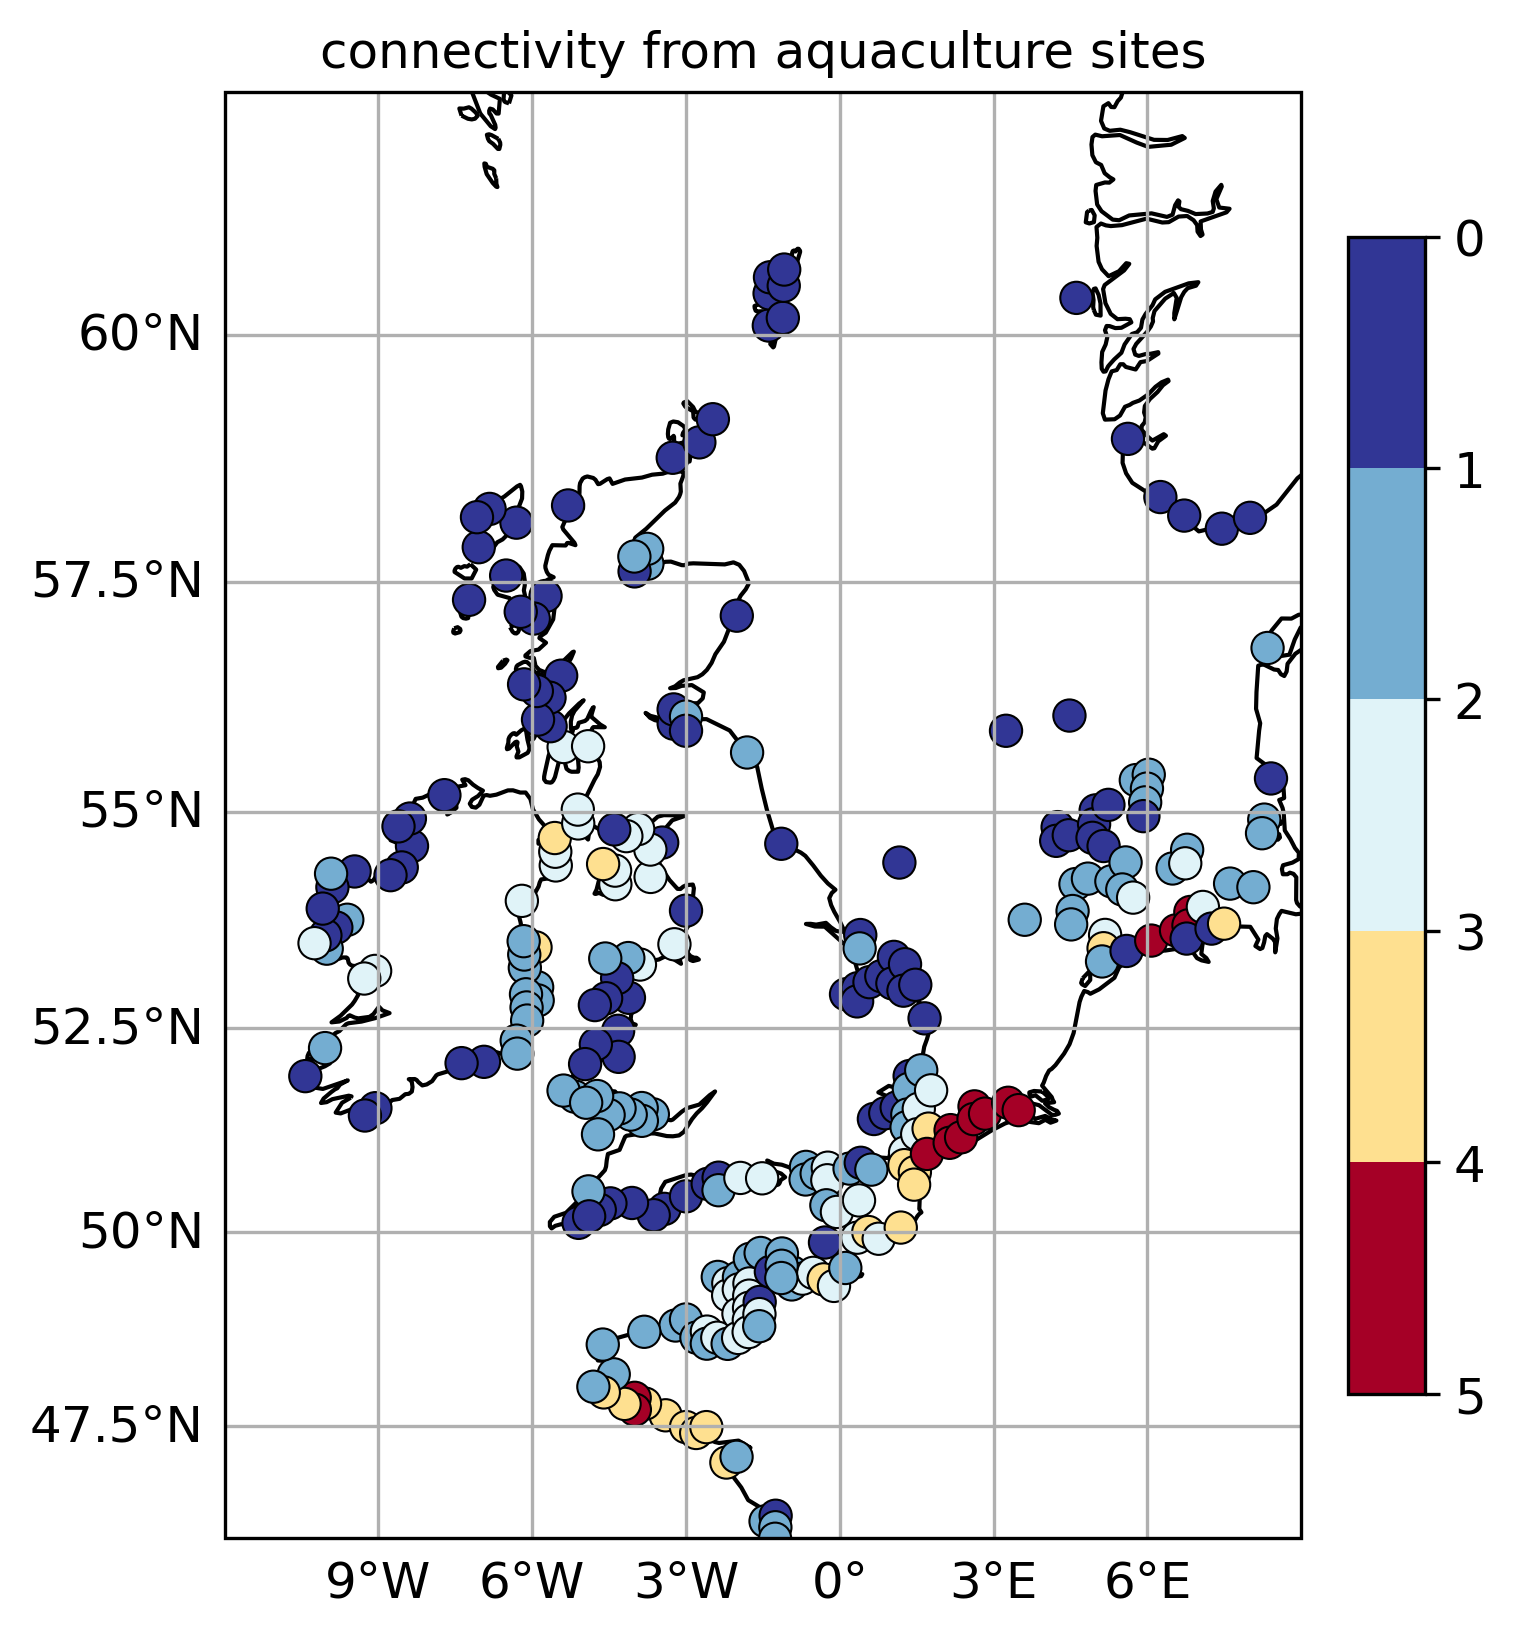

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

fig.set_dpi(300)

bins = [0, 1, 2, 3, 4, 5]
category_colors = [
    '#313695','#74add1','#e0f3f8','#fee090','#f46d43','#a50026',
]

cmap = ListedColormap(category_colors)
norm = BoundaryNorm(boundaries=bins, ncolors=len(category_colors))

scatter = ax.scatter(
    known_his_plot_df["lon_hex0"], known_his_plot_df["lat_hex0"],
    c=known_his_plot_df["num_connected_hab"],
    cmap=cmap, norm=norm,
    edgecolor='black', linewidth=0.5, s=60,
    transform=cartopy.crs.PlateCarree()
)


ax.coastlines(zorder=0)
ax.set_extent([-12, 9, 46, 62])
gl1 = ax.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 12}
gl1.ylabel_style = {'size': 12}
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(bins)
cbar.ax.invert_yaxis()  

#fig.savefig("plots/041_rest-sites_risk-analsysis_highly_connected_his_to_hab_05m_00-07.pdf")